##  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> Cars4U
##  <span style="font-family: Arial; font-weight:bold;font-size:1.9em;color:#0e92ea"> Used Car Price Predictive Model


    Brian Hall
    DSBA - Project 3
    05/21/2021
    
<font color=darkblue>
&nbsp;
    
## Problem
There is high demand for used cars in the Indian Market today and the market shows rapid growth, in 2018-19 second-hand cars sales were higher than new. Unfortunately the used car market has huge uncertainty in both pricing and supply which makes it difficult to understand and grow as a business in this market.  
    
## Objective
Cars4U needs a pricing model that can effectively predict the price of used cars.  Ideally this model would help the business in devising profitable strategies using differential pricing, thus never selling a used car below market price.

Build a predictive model that will allow Cars4U to gain a foothold in this market by utilizing a provided data set of used cars.  This will be accomplished through the following activities.

1. Exploration and visualization of the dataset
2. Build a linear regression model to predict the prices of used cars
3. Generate a set of insights and recommendations that will help the business
    
    
## Data    
Data has been provided via CSV (used_cars_data.csv - 768 kb)
    
The data is assumed to be a random subset of used car sales in India from 1996 - 2019

1. S.No. : Serial Number
2. Name : Name of the car which includes Brand name and Model name
3. Location : The location in which the car is being sold or is available for purchase Cities
4. Year : Manufacturing year of the car
5. Kilometers_driven : The total kilometers driven in the car by the previous owner(s) in KM.
6. Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
7. Transmission : The type of transmission used by the car. (Automatic / Manual)
8. Owner : Type of ownership
9. Mileage : The standard mileage offered by the car company in kmpl or km/kg
10. Engine : The displacement volume of the engine in CC.
11. Power : The maximum power of the engine in bhp.
12. Seats : The number of seats in the car.
13. New_Price : The price of a new car of the same model in INR Lakhs.(1 Lakh = 100, 000)
14 Price : The price of the used car in INR Lakhs (1 Lakh = 100, 000)


#### The data contains:
    
- 7253 rows and 13 columns (1 duplicate column dropped)
- Column Keys match data description provided
- 9 variables of type object
- 2 variables of type int64
- 2 variable of type float64
- Missing data | 7760 values total
    - New_Price 86%
    - Price 17%
    - Seats < 1% 
    - Engine < 1%
    - Power < 1%
    - Mileage 2 values

  
#### Data Treatment (pre-model):    
- New Price missing 86% of values and will be dropped
- New column of Age (age of the car from today) will be added based on Years
- Name will be split into Make, Model & Sub_Class
- Units will be dropped from Fuel_Type, Mileage, Engine & Power
                
## Model Overview & Performance
OLSRES4 was the highest performing model that met linear regression assumptions and showed a good overall fit with the training data
- MAE      03177
- MAPE     8.163
- RMSE     0.242
- R^2      0.32
- Adj R^2  0.931

This means OLSRES4 will be able to:
- Explain 93% of the datas variation          
- Predict within 8% of the used car Price

Key Variables for the model:
- Mileage
- Engine
- Power
- Age

                
Surprisingly Kilometers_Driven and Location showed very little significance in the overall performance of the model.  However these should not be removed from the model as more data could increase their significance and they could be important for ongoing insights.
                
Although the model shows good results some assumptions such as normality could be tightened through adding additional data and other methods to increase the reliability to make inferences from the model.   

12 Models were tested, most were iterations looking at outlier treatment, transformations and investigating problems with assumptions. Most of these are not shown, however are documented in the notebook
- There were 13 columns that resulted in 56 features going into the model
- The final model contains 49 features plus the target variable of Price     


#### Advised by GreatLearning to Keep Make & Fuel Type - Below comments are kept for documentation 
Make (previously Name) showed significant positive impact on the model (+10% R^2), however it caused assumptions to not be met by showing perfect multicollinarity and has potential to make the model unstable and so was removed.  It is possible that Make was highly correlated to Engine & Power.  This should be investigated further as Make would be an important feature for ongoing insights
                
Fuel_Type was removed due to perfect multicollinarity, possibly correlated to Engine and Power.  When included in the model it did not show significant impact.
                
             

### Import libraries and set global options

In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import pylab
import scipy.stats as stats
import statsmodels.stats.api as sms

warnings.filterwarnings("ignore")

%matplotlib inline

# Removes the limit from the number of displayed columns and rows.
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 200)

In [2]:
# Outlier Treatment Functions
def treat_outliers(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.25)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df

def treat_outliers_high(df, col):
    """
    treats outliers in a variable
    col: str, name of the numerical variable
    df: dataframe
    col: name of the column
    """
    Q1 = df[col].quantile(0.0)  # 25th quantile
    Q3 = df[col].quantile(0.75)  # 75th quantile
    IQR = Q3 - Q1
    Lower_Whisker = Q1 - 0 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    # all the values smaller than Lower_Whisker will be assigned the value of Lower_Whisker
    # all the values greater than Upper_Whisker will be assigned the value of Upper_Whisker
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df
def treat_outliers_all(df, col_list):
    """
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    """
    for c in col_list:
        df = treat_outliers(df, c)

    return df

### Retrieve, examine & prepare data
used_cars_data.csv - 768 kb

In [3]:
#REad in data and sample
c4u = pd.read_csv("used_cars_data.csv", index_col=0)
print(f'There are {c4u.shape[0]} rows and {c4u.shape[1]} columns.')  # f-string

np.random.seed(2021)
c4u.sample(n=10)

There are 7253 rows and 13 columns.


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
S.No.,,,,,,,,,,,,,
5860,Mahindra Thar CRDe AC,Coimbatore,2019,16392,Diesel,Manual,First,16.55 kmpl,2498 CC,105 bhp,6.0,NaN,10.36
2628,Hyundai Verna Transform SX VTVT,Bangalore,2011,61000,Petrol,Manual,Second,16.2 kmpl,1599 CC,103.2 bhp,5.0,NaN,3.40
860,Toyota Innova 2.5 G (Diesel) 7 Seater BS IV,Kolkata,2011,98000,Diesel,Manual,Second,12.8 kmpl,2494 CC,102 bhp,8.0,NaN,5.50
2847,Hyundai Getz GLS,Pune,2005,86000,Petrol,Manual,Second,15.3 kmpl,1341 CC,83 bhp,5.0,NaN,0.45
4900,Hyundai Santro Xing XL AT eRLX Euro III,Hyderabad,2007,71000,Petrol,Automatic,First,17.0 kmpl,1086 CC,null bhp,5.0,NaN,2.40
2274,Renault Duster 110PS Diesel RxZ,Pune,2012,135000,Diesel,Manual,First,19.01 kmpl,1461 CC,108.45 bhp,5.0,NaN,5.40
6629,Honda Jazz 1.2 V CVT i VTEC,Chennai,2015,44550,Petrol,Automatic,First,19.0 kmpl,1199 CC,88.7 bhp,5.0,NaN,NaN
2352,Renault Duster 110PS Diesel RxZ,Bangalore,2014,74500,Diesel,Manual,First,19.01 kmpl,1461 CC,108.45 bhp,5.0,NaN,7.95
1677,Hyundai Grand i10 1.2 Kappa Magna,Delhi,2017,12248,Petrol,Manual,First,18.9 kmpl,1197 CC,81.86 bhp,5.0,6.54 Lakh,4.90


### Data Overview

In [4]:
#Examine data
c4u.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7253 entries, 4079 to 6659
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Year               7253 non-null   int64  
 3   Kilometers_Driven  7253 non-null   int64  
 4   Fuel_Type          7253 non-null   object 
 5   Transmission       7253 non-null   object 
 6   Owner_Type         7253 non-null   object 
 7   Mileage            7251 non-null   object 
 8   Engine             7207 non-null   object 
 9   Power              7207 non-null   object 
 10  Seats              7200 non-null   float64
 11  New_Price          1006 non-null   object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 793.3+ KB


7253 rows

13 columns

9 variables of type object

2 variables of type int64

2 variable of type float64



### Convert variables
#### Convert | Location, Year, Fuel_type, Transmission, Owner_Type, Seats to type category

In [5]:
# Convert Location, Year, Fuel_Type, Transmission, Owner_Type, Seats to category
c4u2 = c4u.astype({"Location":'category', "Year":'category', "Fuel_Type":'category', "Transmission":'category',
                   "Owner_Type":'category'})
#"Seats":'category'
print(c4u2.dtypes)

Name                   object
Location             category
Year                 category
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage                object
Engine                 object
Power                  object
Seats                 float64
New_Price              object
Price                 float64
dtype: object


#### Prepare and Convert | Mileage, Engine, Power to float64 

In [6]:
#Examine Data
c4u2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7253 entries, 4079 to 6659
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Name               7253 non-null   object  
 1   Location           7253 non-null   category
 2   Year               7253 non-null   category
 3   Kilometers_Driven  7253 non-null   int64   
 4   Fuel_Type          7253 non-null   category
 5   Transmission       7253 non-null   category
 6   Owner_Type         7253 non-null   category
 7   Mileage            7251 non-null   object  
 8   Engine             7207 non-null   object  
 9   Power              7207 non-null   object  
 10  Seats              7200 non-null   float64 
 11  New_Price          1006 non-null   object  
 12  Price              6019 non-null   float64 
dtypes: category(5), float64(2), int64(1), object(5)
memory usage: 547.1+ KB


#### Remove units where applicable & convert to float

In [7]:
# split each variable, convert to float64 and drop resulting additional unit columns
c4u2[['Mileage','mUnit']] = c4u2['Mileage'].str.split(' ',expand=True)
c4u2[['Engine','eUnit']] = c4u2['Engine'].str.split(' ',expand=True)
c4u2[['Power', 'pUnit']] = c4u2['Power'].str.split(' ', expand=True)
# Convert Power to numeric and handle 'null' values prior to converting to float64
c4u2['Power'] = pd.to_numeric(c4u2['Power'].str.replace(",", ""), errors='coerce')
c4u2 = c4u2.astype({"Mileage":'float64', "Engine": 'float64', "Power":'float64'})
c4u2 = c4u2.drop(['mUnit', 'eUnit', 'pUnit'], axis = 1)
print(c4u2.dtypes)
c4u2.head()

Name                   object
Location             category
Year                 category
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage               float64
Engine                float64
Power                 float64
Seats                 float64
New_Price              object
Price                 float64
dtype: object


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
S.No.,,,,,,,,,,,,,
4079,Land Rover Range Rover 3.0 Diesel LWB Vogue,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,2.3 Cr,160.00
5781,Lamborghini Gallardo Coupe,Delhi,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.0,2.0,NaN,120.00
5919,Jaguar F Type 5.0 V8 S,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,NaN,100.00
1505,Land Rover Range Rover Sport SE,Kochi,2019,26013,Diesel,Automatic,First,12.65,2993.0,255.0,5.0,1.39 Cr,97.07
1974,BMW 7 Series 740Li,Coimbatore,2018,28060,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,NaN,93.67


#### Split name into Make, Model & Sub_Class.  Land Rover and Mini Cooper will further additional processing due to additional spaces.

In [8]:
#Split name into Make, Model & Sub_Class. Land Rover and Mini Cooper will further additional processing due to additional spaces.
c4u2 = c4u2.replace(to_replace ='Land Rover', value = 'Land_Rover', regex = True)
c4u2 = c4u2.replace(to_replace ='Range Rover', value = 'Range_Rover', regex = True)
c4u2 = c4u2.replace(to_replace ='Mini Clubman Cooper', value = 'Mini Cooper Clubman', regex = True)
c4u2 = c4u2.replace(to_replace ='Mini Countryman Cooper', value = 'Mini Cooper Countryman', regex = True)
c4u2 = c4u2.replace(to_replace ='Mini Cooper', value = 'Mini_Cooper', regex = True)


In [9]:
# Check for Land Rover conversion success
land = c4u2['Name'].str.startswith('Land')

In [10]:
#split naeme and model into new cols
c4u2[['Name','Model']] = c4u2['Name'].str.split(' ', n=1, expand=True)

In [11]:
#split model and sub_class into new cols
c4u2[['Model','Sub_Class']] = c4u2['Model'].str.split(' ', n=1, expand=True)

In [12]:
#Rename the name col
c4u2.rename(columns={'Name': 'Make'}, inplace=True)

In [13]:
#change new cols type to category
c4u2 = c4u2.astype({"Make":'category', "Model":'category', "Sub_Class":'category'})

In [14]:
#Sample to check data
c4u2.sample(n=10)

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Model,Sub_Class
S.No.,,,,,,,,,,,,,,,
4032,Hyundai,Delhi,2014,42000,Diesel,Manual,First,24.00,1120.0,70.00,5.0,NaN,3.50,Grand,i10 CRDi Magna
73,Nissan,Kochi,2015,56066,Diesel,Manual,First,19.64,1461.0,108.50,5.0,16.65 Lakh,6.92,Terrano,XV D Pre
4157,Mahindra,Pune,2013,55000,Diesel,Manual,First,15.10,2179.0,140.00,7.0,NaN,8.50,XUV500,W8 4WD
5707,Hyundai,Kochi,2018,40175,Diesel,Manual,Second,22.54,1396.0,88.73,5.0,NaN,6.36,i20,1.4 Sportz
6851,Skoda,Pune,2016,47000,Diesel,Automatic,First,21.72,1498.0,108.40,5.0,15.11 Lakh,NaN,Rapid,1.5 TDI AT Ambition
2346,Mahindra,Chennai,2013,234000,Diesel,Manual,Second,14.00,2489.0,95.00,8.0,NaN,3.50,Xylo,D2 BSIV
6312,Audi,Coimbatore,2015,53093,Diesel,Automatic,Second,12.07,2967.0,241.40,7.0,NaN,NaN,Q7,3.0 TDI Quattro Premium Plus
7155,Mercedes-Benz,Mumbai,2014,45000,Diesel,Automatic,First,19.27,2143.0,167.62,5.0,NaN,NaN,New,C-Class C 220d Avantgarde Edition C
3764,Mahindra,Delhi,2014,86000,Diesel,Manual,First,15.10,2179.0,140.00,7.0,NaN,7.85,XUV500,W8 2WD


#### Convert year into new Feature - Age -  suspect that it will perform better in models

In [15]:
# Function to calculate age from given year
from datetime import datetime, date

def get_age(myear):
    myear = datetime.strptime(str(myear), "%Y").date()
    today = date.today()
    return (today.year - myear.year)

In [16]:
# Create Age Feature from Year & convert to type int64
c4u2['Age'] = c4u2['Year'].apply(get_age)
c4u2['Age'] = c4u2['Age'].astype('int64')
c4u2.head()

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,,
4079,Land_Rover,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,2.3 Cr,160.00,Range_Rover,3.0 Diesel LWB Vogue,4
5781,Lamborghini,Delhi,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.0,2.0,NaN,120.00,Gallardo,Coupe,10
5919,Jaguar,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,NaN,100.00,F,Type 5.0 V8 S,6
1505,Land_Rover,Kochi,2019,26013,Diesel,Automatic,First,12.65,2993.0,255.0,5.0,1.39 Cr,97.07,Range_Rover,Sport SE,2
1974,BMW,Coimbatore,2018,28060,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,NaN,93.67,7,Series 740Li,3


In [17]:
c4u2['Age'].dtype

dtype('int64')

### Check for Missing and Duplicate Data

In [18]:
# -- Check for missing data
def findNulls(df):
    numOfNulls = df.isnull().sum().sort_values(ascending=False)
    percentOfNulls = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missingData = pd.concat([numOfNulls, percentOfNulls], axis=1, keys=['numOfNulls', 'percentOfNulls'])
    return missingData
print(findNulls(c4u2))

# -- Check for duplicate rows
print('')
print('Before Duplicate Check', c4u2.shape)
c4u2Obj = c4u2
duplicatec4u2Row = c4u2Obj[c4u2Obj.duplicated()]
print('Duplicated Rows: ', len(duplicatec4u2Row))
print('')
print(duplicatec4u2Row)


print('')
print('After Duplicate Check', c4u2.shape)

                   numOfNulls  percentOfNulls
New_Price                6247        0.861299
Price                    1234        0.170136
Power                     175        0.024128
Seats                      53        0.007307
Engine                     46        0.006342
Sub_Class                   3        0.000414
Mileage                     2        0.000276
Age                         0        0.000000
Model                       0        0.000000
Owner_Type                  0        0.000000
Transmission                0        0.000000
Fuel_Type                   0        0.000000
Kilometers_Driven           0        0.000000
Year                        0        0.000000
Location                    0        0.000000
Make                        0        0.000000

Before Duplicate Check (7253, 16)
Duplicated Rows:  1

        Make Location  Year  Kilometers_Driven Fuel_Type Transmission  \
S.No.                                                                   
6582   Honda   M

#### New_Price has 86% missing values and will be dropped

Price has 17% missing values and will need to be imputed

Seats has less than 1% missing values and needs further evaluation to determine action

Engine & Power are each missing less than 1%.  Evaluate further to determine action.

Mileage is missing 2 values which will be imputed with median or mean

#### 1 Duplicate row dropped 

In [19]:
# Drop New_Price
c4u2.drop('New_Price', axis=1, inplace=True)
c4u2.head(2)

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
4079,Land_Rover,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,160.0,Range_Rover,3.0 Diesel LWB Vogue,4
5781,Lamborghini,Delhi,2011,6500,Petrol,Automatic,Third,6.40,5204.0,560.0,2.0,120.0,Gallardo,Coupe,10


In [20]:
c4u2.dtypes

Make                 category
Location             category
Year                 category
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage               float64
Engine                float64
Power                 float64
Seats                 float64
Price                 float64
Model                category
Sub_Class            category
Age                     int64
dtype: object

#### Observation
### The 46 missing entries for engine are also missing from power & seats and many for price.  We will drop these and recheck

In [21]:
#Check for nulls
print(c4u2.shape)
c4u2.dropna(subset = ['Engine'], inplace=True)
c4u2[c4u2.Engine.isnull()]

(7253, 15)


,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,


In [22]:
# Check for nulls
print(findNulls(c4u2))

                   numOfNulls  percentOfNulls
Price                    1224        0.169835
Power                     129        0.017899
Seats                       7        0.000971
Sub_Class                   3        0.000416
Mileage                     2        0.000278
Age                         0        0.000000
Model                       0        0.000000
Engine                      0        0.000000
Owner_Type                  0        0.000000
Transmission                0        0.000000
Fuel_Type                   0        0.000000
Kilometers_Driven           0        0.000000
Year                        0        0.000000
Location                    0        0.000000
Make                        0        0.000000


Dropping missing Engine rows decreased missing in power, price, model & seats

Check power nulls for patterns

In [23]:
# Check power shape & look for patterns
pm = c4u2.loc[(c4u2.Power.isnull())]
pm.shape
#pm

(129, 15)

#### Observation
### There doesn't seem to be any specific pattern to Power's 127 missing values.  Will replace with median due to number of outliers

In [24]:
#Impute power with median & check for nulls
c4u2.loc[(c4u2.Power.isnull()),'Power'] = c4u2.Mileage.median()
c4u2.loc[(c4u2.Power.isnull())]

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,


### Perform statistical overview of the data

In [25]:
# -- Get overview of the data
c4u2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Make,7207,33,Maruti,1431,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,7207,11,Mumbai,945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,7207,23,2015,926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometers_Driven,7207,NaN,NaN,NaN,58633.5,84649.2,171,34000,53226,73000,6.5e+06
Fuel_Type,7207,5,Diesel,3840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transmission,7207,2,Manual,5169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Owner_Type,7207,4,First,5926,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,7205,NaN,NaN,NaN,18.1783,4.513,0,15.2,18.19,21.1,33.54
Engine,7207,NaN,NaN,NaN,1616.57,595.285,72,1198,1493,1968,5998
Power,7207,NaN,NaN,NaN,111.072,54.4756,18.19,74,91.72,138.03,616


In [26]:
# looking at value counts for non-numeric features

num_to_display = 35  # defining this up here so it's easy to change later if I want
for colname in c4u2.dtypes[c4u2.dtypes == 'category'].index:
    val_counts = c4u2[colname].value_counts(dropna=False)  # i want to see NA counts
    print(val_counts[:num_to_display])
    if len(val_counts) > num_to_display:
        print(f'Only displaying first {num_to_display} of {len(val_counts)} values.')
    print('\n\n') # just for more space between 

Maruti           1431
Hyundai          1332
Honda             737
Toyota            504
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          330
BMW               305
Audi              285
Tata              228
Skoda             201
Renault           170
Chevrolet         151
Nissan            117
Land_Rover         64
Jaguar             48
Mitsubishi         36
Fiat               34
Mini_Cooper        31
Volvo              28
Jeep               19
Porsche            19
Datsun             17
ISUZU               3
Force               3
Isuzu               2
Bentley             2
Lamborghini         1
Hindustan           1
OpelCorsa           1
Smart               1
Ambassador          1
Name: Make, dtype: int64



Mumbai        945
Hyderabad     875
Coimbatore    770
Kochi         768
Pune          755
Delhi         655
Kolkata       648
Chennai       589
Jaipur        496
Bangalore     432
Ahmedabad     274
Name: Location, dtype: int64



2015    926
2014

#### Observations
There are 33 makes, 221 models, 11 locations, 5 fuel types, 4 owner types, 9 seat types

There are more Natuti than any other make with 1444 observations

Top location is Mumbai with 948 cars

Most prominent year is 2015

Diesel is the most common fuel type with 3852 observations

Most cars (5951) have had only 1 owner 

5 seats is the most common in cars (6046)

58699 is the average KM driven

18.41 is the average mileage

There are only 12 owner types of fourth and above, consider dropping these

There are only 12 LPG and 2 Electric for Fuel Type, consider dropping these

For seats there are 53 that are missing, impute with median or mean depending on distribution

The following models have only a few entries.  Look at distributions to see how these are impacting

Bentley, Lamborghini, Hindustan, OpelCorsa, Smart, Ambassador


Model and Sub_Class will not likely provide value in modeling, consider dropping



#### Look at Make(s) with few entries <= 3

In [27]:
#Check make for small number of rows
make_list = ['Bentley', 'Lamborghini', 'Hindustan', 'OpelCorsa', 'Smart', 'Ambassador', 'ISUZU', 'Force', 'Isuzu']
for cols in make_list:
    print(c4u2[c4u2['Make'] == cols])
    #print(c4u2[c4u2['Make'] == cols].index)
    

          Make   Location  Year  Kilometers_Driven Fuel_Type Transmission  \
S.No.                                                                       
5521   Bentley  Hyderabad  2006              48000    Petrol    Automatic   
6354   Bentley  Bangalore  2008              31200    Petrol    Automatic   

      Owner_Type  Mileage  Engine  Power  Seats  Price        Model  \
S.No.                                                                 
5521       First      8.6  5998.0  552.0    4.0   59.0  Continental   
6354      Second     10.2  5998.0  616.0    5.0    NaN       Flying   

         Sub_Class  Age  
S.No.                    
5521   Flying Spur   15  
6354      Spur W12   13  
              Make Location  Year  Kilometers_Driven Fuel_Type Transmission  \
S.No.                                                                         
5781   Lamborghini    Delhi  2011               6500    Petrol    Automatic   

      Owner_Type  Mileage  Engine  Power  Seats  Price     Model

#### With the exception of the Lambrogini these cars do not seem to have much that is out of the average.  Lambrogini is the second most expensive.  Dropping these cars to reduce complexity and missing values.
### Dropping 15 rows -  on 9 Makes =  'Bentley', 'Lamborghini', 'Hindustan', 'OpelCorsa', 'Smart', 'Ambassador', 'ISUZU', 'Force', 'Isuzu'


In [28]:
# Drop all rows containing Makes in make_list
print(c4u2.shape)
for cols in make_list:
    #c4u2[c4u2['Make'] == cols].index
    c4u2.drop(c4u2[c4u2['Make'] == cols].index, inplace=True)
print(c4u2.shape)

(7207, 15)
(7192, 15)


In [29]:
#Check make counts
c4u2.Make.unique().value_counts()

Land_Rover       1
Jaguar           1
BMW              1
Mercedes-Benz    1
Porsche          1
Audi             1
Ford             1
Mini_Cooper      1
Toyota           1
Volvo            1
Mitsubishi       1
Skoda            1
Volkswagen       1
Jeep             1
Hyundai          1
Tata             1
Mahindra         1
Honda            1
Renault          1
Maruti           1
Chevrolet        1
Nissan           1
Fiat             1
Datsun           1
dtype: int64

## EDA, Data Cleaning, Feature Engineering
### Uni-Variate Analysis

In [30]:
# Function to create histogram and boxplot for numerical attributes
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2,
                                           sharex = True,
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           )
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') 
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) 
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') 
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') 

# Function to create percentages for count plots - categorical attributes
def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) 
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()           
        ax.annotate(percentage, (x, y), size = 12) 
    plt.show() 

In [31]:
c4u2.head(2)

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
4079,Land_Rover,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,160.0,Range_Rover,3.0 Diesel LWB Vogue,4
5919,Jaguar,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,100.0,F,Type 5.0 V8 S,6


### Kilometers Driven

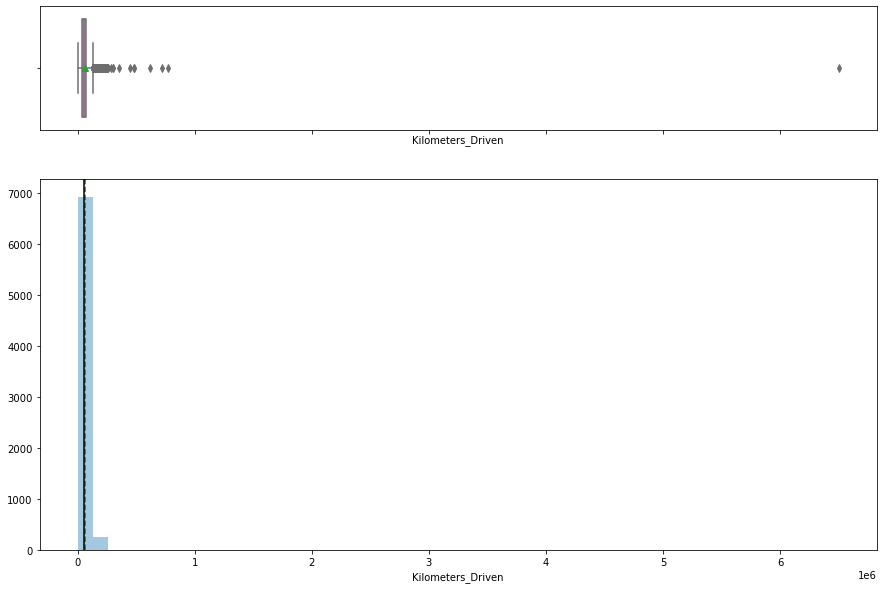

In [32]:
# Kilometers_Driven Distribution
histogram_boxplot(c4u2["Kilometers_Driven"])


In [33]:
#c4u2[c4u2['Kilometers_Driven'] > 100000]
c4u2['Kilometers_Driven'].sort_values(ascending=False)


S.No.
2328    6500000
340      775000
1860     720000
358      620000
2823     480000
         ...   
1598       1000
5339       1000
1161       1000
5606        600
1361        171
Name: Kilometers_Driven, Length: 7192, dtype: int64

#### Observation
Heavily right skewed with one extreme outlier of 6.5 million.  I suspect this is an entry error

#### change value at index 2328 to 650,000


In [34]:
#c4u2.loc[(c4u2['S.No.'] == '2328'),'Kilometers_Driven']=650000
c4u2.at[2328,'Kilometers_Driven']= 650000

In [35]:
#Check KM Driven range
c4u2['Kilometers_Driven'].sort_values(ascending=False)

S.No.
340     775000
1860    720000
2328    650000
358     620000
2823    480000
         ...  
1598      1000
5339      1000
1161      1000
5606       600
1361       171
Name: Kilometers_Driven, Length: 7192, dtype: int64

Replot Kilometers_Driven

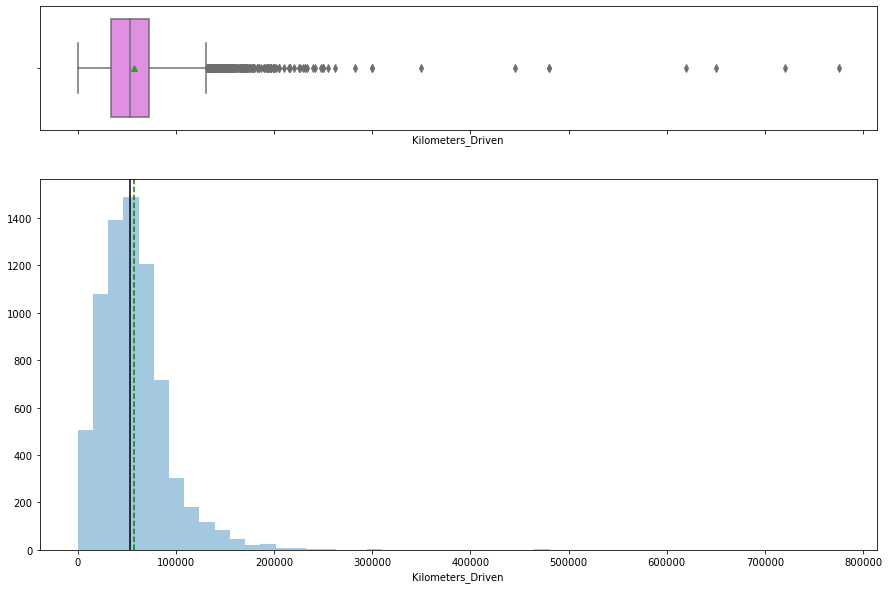

In [36]:
#plot KM Driven 
histogram_boxplot(c4u2["Kilometers_Driven"])

#### Observations
KM Driven is highly right skewed with many high outliers



### Mileage

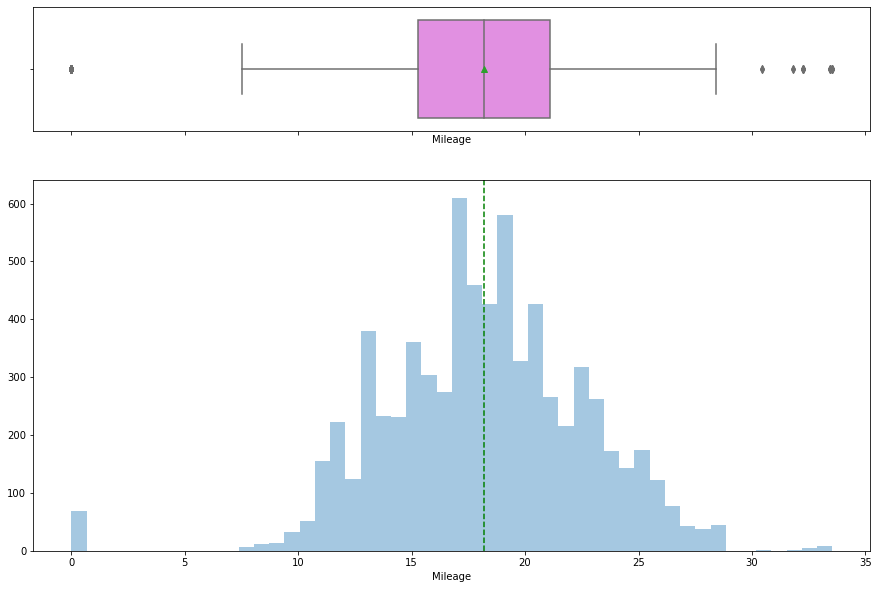

In [37]:
#Plot mileage
histogram_boxplot(c4u2["Mileage"])

#### Observation
Mileage seems to have a fairly normal distribution with a few outliers.  Some outliers near zero look suspicious.


In [38]:
#Check mileage shape
m0 = c4u2[c4u2['Mileage'] == 0]
m0.shape

(68, 15)

In [39]:
# Check mileage for nulls
c4u2.loc[(c4u2.Mileage.isnull())]


,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
4446,Mahindra,Chennai,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.00,E,Verito D4,5
4904,Toyota,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,12.75,Prius,2009-2016 Z4,10


### There are 80 entries that are 0 and 2 missing.  Mileage mean and median are relatively close but will replace with median due to several outliers

In [40]:
# Impute mileage with median
c4u2.loc[(c4u2.Mileage == 0),'Mileage'] = c4u2.Mileage.median()
c4u2.loc[(c4u2.Mileage.isnull()),'Mileage'] = c4u2.Mileage.median()

c4u2.loc[(c4u2.Mileage.isnull())]

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,


In [41]:
#Check mileage shape
m0 = c4u2[c4u2['Mileage'] == 0]
m0.shape

(0, 15)

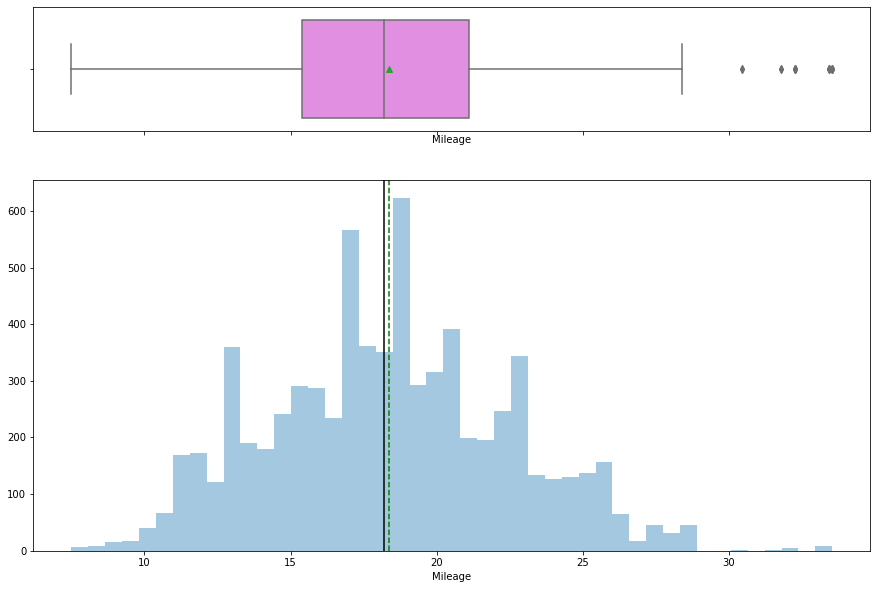

In [42]:
# replot Mileage
histogram_boxplot(c4u2["Mileage"])

In [43]:
c4u2.head(2)

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
4079,Land_Rover,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,160.0,Range_Rover,3.0 Diesel LWB Vogue,4
5919,Jaguar,Hyderabad,2015,8000,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,100.0,F,Type 5.0 V8 S,6


### Engine

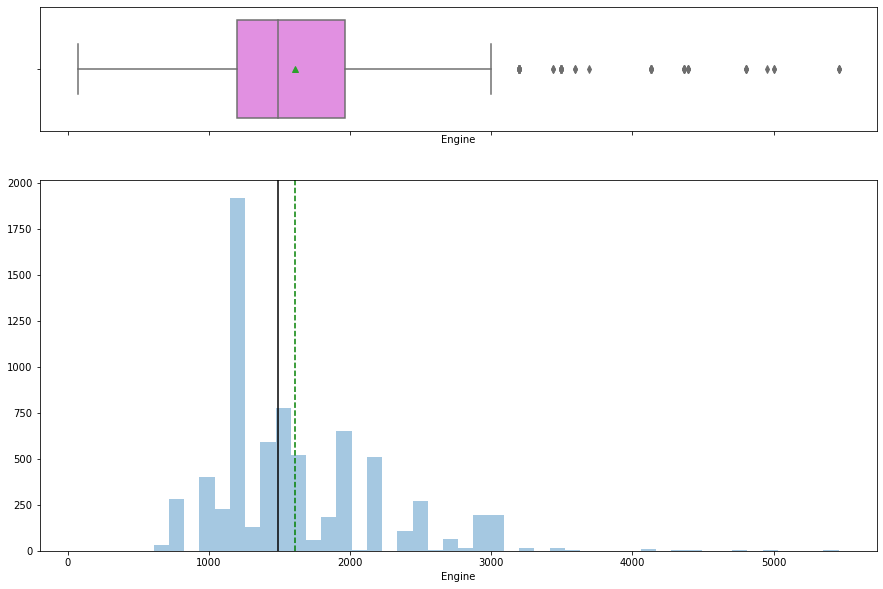

In [44]:
# Engine Distribution
histogram_boxplot(c4u2["Engine"])

#### Observations
Engine is slightly normal with many outliers above 3000.  Check the higher outliers for patterns and treatment
Median and mean are relatively close around 1500 
There is a spike in engne CC's around 1200

In [45]:
# check engine for number of values above 3000
eh = c4u2[c4u2['Engine'] > 3000]
print(eh.shape)


(62, 15)


#### Observation
There are 62 values above 3000 CC, the highest of which are high performing cars.  We will leave these outliers as they don't seem out of place for the car Makes

In [46]:
c4u2.loc[(c4u2.Engine.isnull())]

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,


### Power

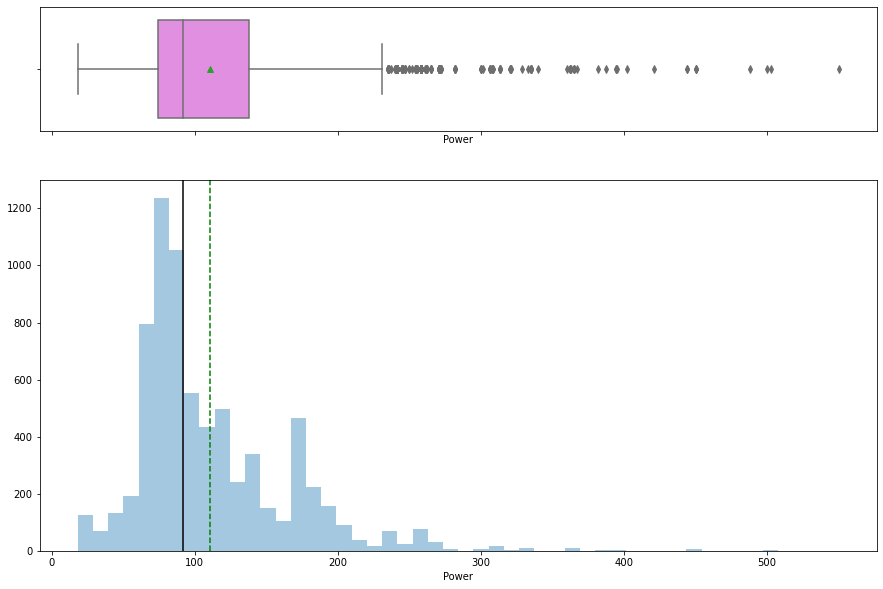

In [47]:
# Power Distribution
histogram_boxplot(c4u2["Power"])

#### Observations
Power is right skewed with many outliers above ~225 which are pulling the mean higher

Mean and median are relative close and we appear to have close to a normal distribution

There are a number of power values that are below 50, this should be checked

The majority of power values are between 75 and 175

In [48]:
# Check power for < 40 entries
ph = c4u2[c4u2['Power'] < 40]
print(ph.shape)
#ph

(198, 15)


In [49]:
# Check power for > 300 entries
ph = c4u2[c4u2['Power'] > 300]
print(ph.shape)

(59, 15)


#### observation
There are 71 power values below 40 and are attributed to "lower end" cars, we will leave these for now
There are 59 power values above 300 with the majority seeming to be to higher end cars and engines, we will leave these for now
as they seem to fit

### Price

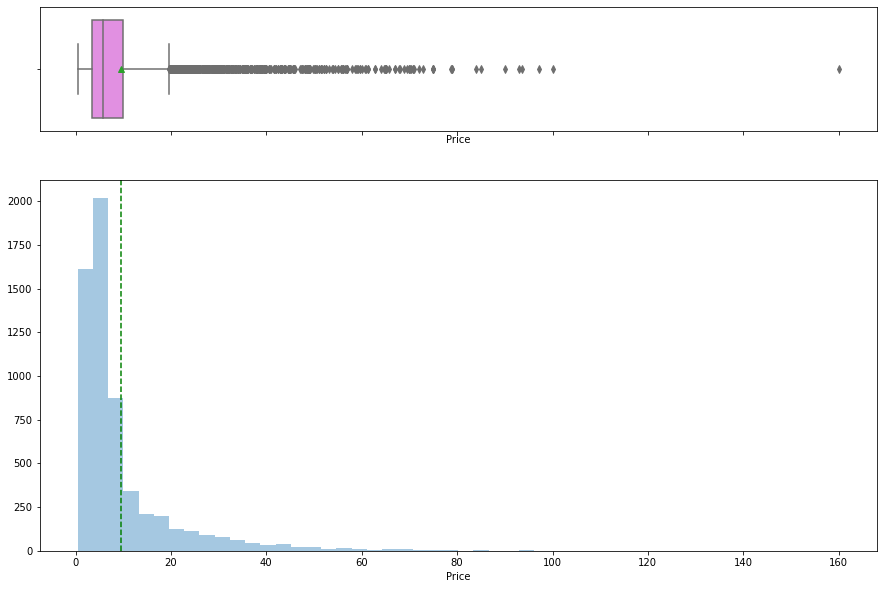

In [50]:
# Price Distribution
histogram_boxplot(c4u2["Price"])

In [51]:
# Check price for > 100 entries
prh = c4u2[c4u2['Price'] > 100]
print(prh.shape)
prh

(1, 15)


,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
4079,Land_Rover,Hyderabad,2017,25000,Diesel,Automatic,First,13.33,2993.0,255.0,5.0,160.0,Range_Rover,3.0 Diesel LWB Vogue,4


In [52]:
# Check price for < 1 entries
prl = c4u2[c4u2['Price'] < 1]
print(prl.shape)
#prl

(75, 15)


In [53]:
# Check price for nulls
prn = c4u2.loc[(c4u2.Price.isnull())]
print(prn.shape)
#prn.sample(n=100)

(1219, 15)


#### Observation
Price is highly right skewed with a huge amount of high outliers above 20 Lakh

#### One outlier at 160 Lakh for a Land Rover is likely an entry mistake and we will set the price to the median

There are no other prices above 100 Lakh (7 Makes were removed, 1 was a 120 Lakh Lanbroghini)

There are 75 prices below 1 Lakh - none with 0

#### There are 1221 prices that are missing with no apparent pattern.  


## Price has been checked by imputing with median as well as capping high outliers.  Both methods create a massive spike in the distribution and cause problems with transformation and models. 

#### --------Transformation of the feature adequately handled outliers, the following is included for documentation ONLY-------------
Outliers > 40 and null rows will be dropped and Price will be imputed with median and outliers capped IF models perform poorly with price outliers included.  Dropping price > 40 will result in 345 rows dropping this is 5.1% of the data.  
Variations on Outliers being capped and missing values dropped /  imputed were performed in multiple models with unsatisfactory results


In [54]:
#check price for low and high values
price_check_l = c4u2[c4u2['Price'] < 40]
price_check_h = c4u2[c4u2['Price'] > 40]
print(price_check_l.shape)
print(price_check_h.shape)


(5801, 15)
(168, 15)


In [55]:
# Drop high outlier of 160Lakh
c4u2.drop(c4u2[c4u2['Price'] == 160].index, inplace=True)
prh = c4u2[c4u2['Price'] > 100]
print(prh.shape)
prh

(0, 15)


,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,


In [56]:
# Drop price nulls
print(c4u2.shape)
c4u2.dropna(subset = ['Price'], inplace=True)
c4u2[c4u2.Price.isnull()]
print(c4u2.shape)

(7191, 15)
(5972, 15)


### The following code has been commented out due to unsatisfactory results using these methods.  They remain in the notebook for documentation of process

In [57]:
# # Drop all prices that are > 40 Lakh
# print(c4u2.shape)
# #c4u2 = c4u2.drop(c4u2[c4u2['Price'] > 40].index, inplace = True)
# print(c4u2[c4u2['Price'] > 40])
# print(c4u2.shape)

In [58]:
# # Cap price outliers to see how it impacts distribution prior to imputing
# treat_outliers_high(c4u2, 'Price')

In [59]:
# # Impute Price NaN with median
# c4u2.loc[(c4u2.Price.isnull()),'Price'] = c4u2.Mileage.median()
# c4u2.loc[(c4u2.Price.isnull())]

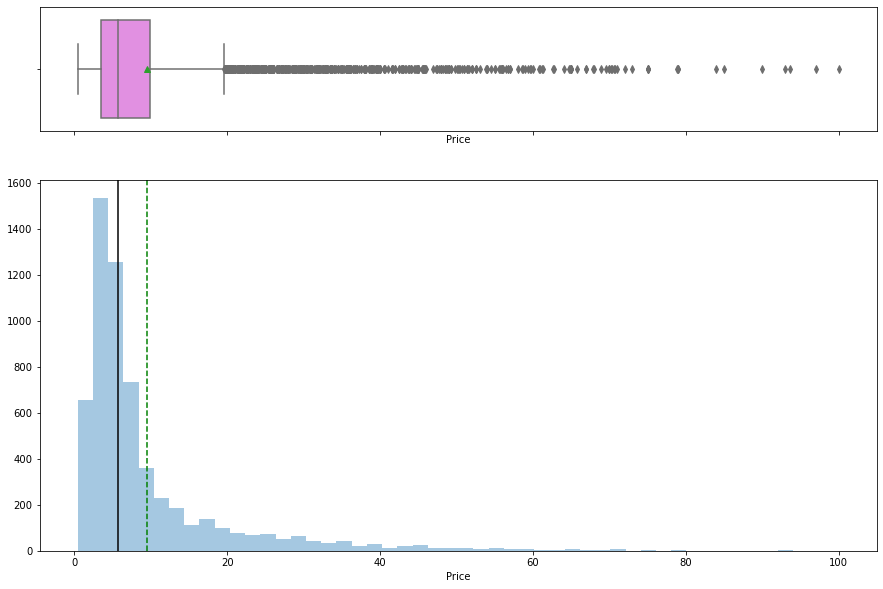

In [60]:
# Price Distribution - recheck
histogram_boxplot(c4u2["Price"])

In [61]:
c4u2.dtypes

Make                 category
Location             category
Year                 category
Kilometers_Driven       int64
Fuel_Type            category
Transmission         category
Owner_Type           category
Mileage               float64
Engine                float64
Power                 float64
Seats                 float64
Price                 float64
Model                category
Sub_Class            category
Age                     int64
dtype: object

### Age

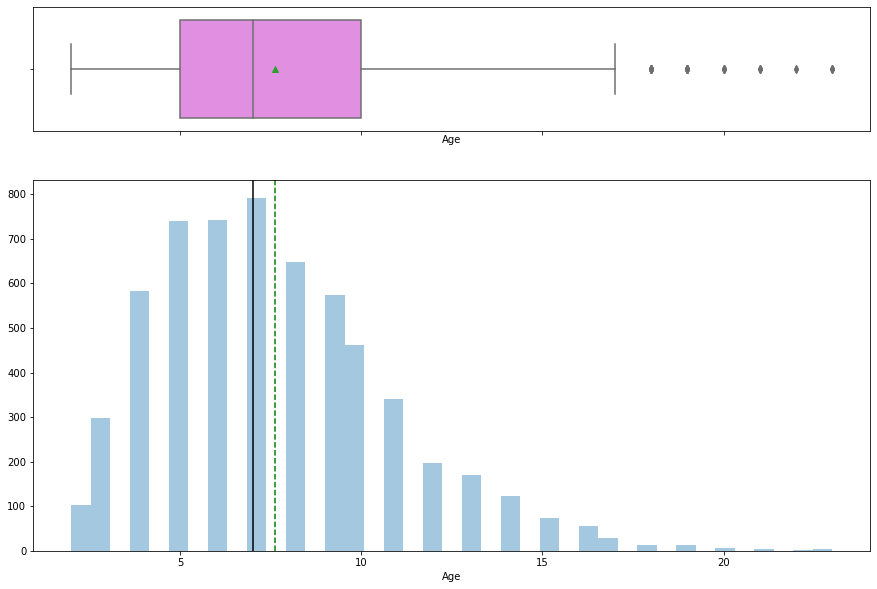

In [62]:
# plot age
histogram_boxplot(c4u2["Age"])

In [63]:
# check age
c4u2['Age'].describe()

count    5972.000000
mean        7.615539
std         3.245426
min         2.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        23.000000
Name: Age, dtype: float64

In [64]:
# check age for values > 20
ah = c4u2[c4u2['Age'] > 20]
print(ah.shape)
#ah

(10, 15)


In [65]:
#check age nulls
an = c4u2.loc[(c4u2.Age.isnull())]
print(an.shape)

(0, 15)


#### Observation
Age is normally distributed with a slight right skew

Age has few outliers all above 18 years

Age range is 2 to 23 years with an average of 7.6 years

Age has no missing values

### Make

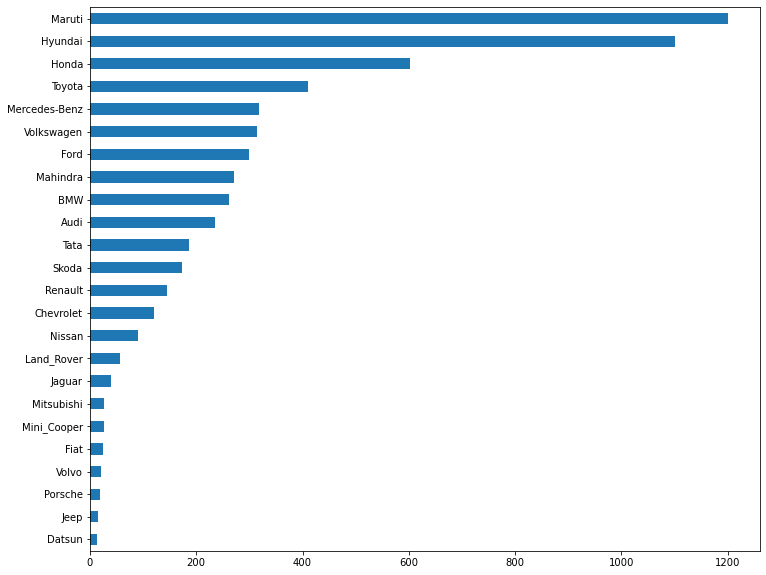

In [66]:
# plot make
plt.figure(figsize=(12,10))
c4u2['Make'].value_counts()[:24].plot(kind='barh').invert_yaxis()

In [67]:
c4u2.Make.describe()

count       5972
unique        24
top       Maruti
freq        1200
Name: Make, dtype: object

In [68]:
#check make nulls
mn = c4u2.loc[(c4u2.Make.isnull())]
print(mn.shape)

(0, 15)


#### Observations
There are 24 unique Makes of cars on the market (15 rows on 9 makes dropped, makes with <= 3 observations)


Maruti and Hyundai dominate the used car market with Honda and Toyota the closest with less than half the number of cars

There are no missing values



### Model

In [69]:
# check model
c4u2.Model.describe()

count      5972
unique      208
top       Swift
freq        343
Name: Model, dtype: object

#### Observation 
There are 211 models representing the 24 unique makes - This feature will not likely contribute to the model, possibly due to correlation with Make.  Will likely Drop

### Sub_Class

In [70]:
# check Sub_Class
c4u2.Sub_Class.describe()

count     5971
unique    1711
top        VDI
freq        79
Name: Sub_Class, dtype: object

#### Observation
There are 1859 Sub-Classes - This feature will not likely contribute to the model, possibly due to correlation with Make. Will likely Drop

### Location

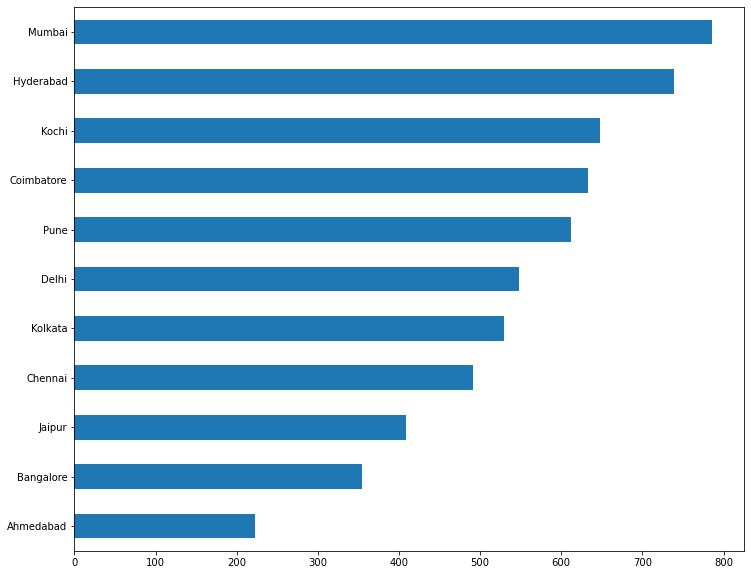

In [71]:
# Plot Location
plt.figure(figsize=(12,10))
c4u2['Location'].value_counts()[:11].plot(kind='barh').invert_yaxis()

In [72]:
# check location
c4u2.Location.describe()

count       5972
unique        11
top       Mumbai
freq         786
Name: Location, dtype: object

In [73]:
# check location shape
ln = c4u2.loc[(c4u2.Location.isnull())]
print(ln.shape)

(0, 15)


#### Observations
There are 11 unique locations with used cars for sale

Mumbai is the location with the most used cars (945)

Location has no missing values

### Fuel Type

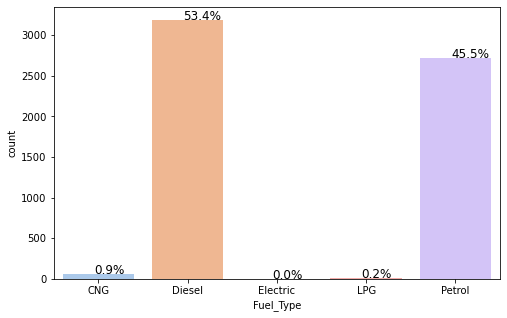

In [74]:
# plot Fuel_tyep
plt.figure(figsize=(8,5))
ax = sns.countplot(c4u2["Fuel_Type"],palette='pastel')
perc_on_bar(ax,c4u2["Fuel_Type"])

In [75]:
# check Fuel_Type
c4u2["Fuel_Type"].describe()

count       5972
unique         5
top       Diesel
freq        3188
Name: Fuel_Type, dtype: object

In [76]:
# check Fuel_Type nulls
ln = c4u2.loc[(c4u2.Location.isnull())]
print(ln.shape)

(0, 15)


#### Observation
There are 4 unique Fuel Types with 

Diesel is the largest Fuel Type at 53%, Followed by Petrol at 46%

CNG, Electric & LPG combined make up about 1%

#### To reduce complexity we will drop CNG, Electric & LPG 

In [77]:
# check Fuel type counts
c4u2.Fuel_Type.value_counts()

Diesel      3188
Petrol      2716
CNG           56
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

In [78]:
# Drop all rows with Fuel_Type = CNG, Electric & LPG
fuelDrop = ['CNG', 'Electric', 'LPG']
print(c4u2.shape)
for cols in fuelDrop:
    c4u2.drop(c4u2[c4u2['Fuel_Type'] == cols].index, inplace=True)
c4u2.reset_index()
print(c4u2.shape)

(5972, 15)
(5904, 15)


In [79]:
# check Fuel type counts
c4u2.Fuel_Type.value_counts()


Diesel      3188
Petrol      2716
LPG            0
Electric       0
CNG            0
Name: Fuel_Type, dtype: int64

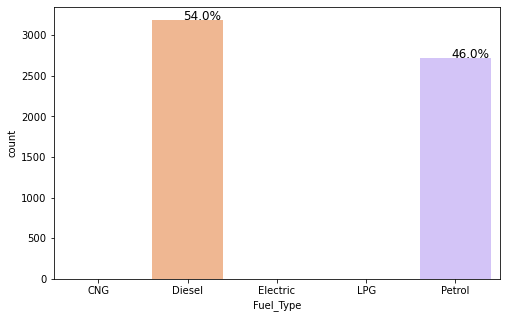

In [80]:
# plot fuel type
plt.figure(figsize=(8,5))
ax = sns.countplot(c4u2["Fuel_Type"],palette='pastel')
perc_on_bar(ax,c4u2["Fuel_Type"])

#### 76 Rows dropped from Fuel_Type

### Transmission

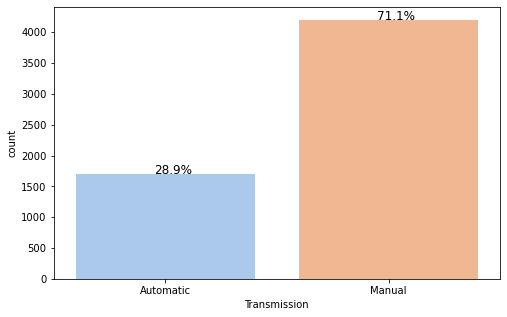

In [81]:
# plot transmission
plt.figure(figsize=(8,5))
ax = sns.countplot(c4u2["Transmission"],palette='pastel')
perc_on_bar(ax,c4u2["Transmission"])

In [82]:
# check fuel type
c4u2["Fuel_Type"].describe()

count       5904
unique         2
top       Diesel
freq        3188
Name: Fuel_Type, dtype: object

In [83]:
#Check transmision nulls
tn = c4u2.loc[(c4u2.Transmission.isnull())]
print(tn.shape)

(0, 15)


#### Observation
There are 2 types of transmission - manual and automatic

Manual is the largest type at 71.5%

There are no missing values

### Owner_Type

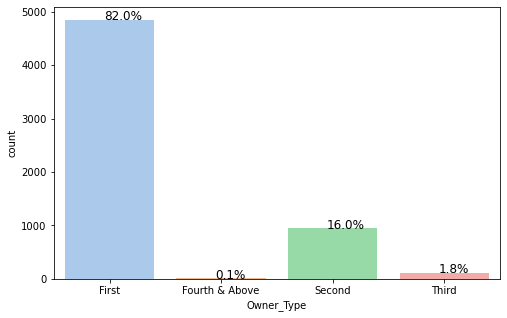

In [84]:
#plot owner type
plt.figure(figsize=(8,5))
ax = sns.countplot(c4u2["Owner_Type"],palette='pastel')
perc_on_bar(ax,c4u2["Owner_Type"])

In [85]:
# describe owner type
c4u2["Owner_Type"].describe()

count      5904
unique        4
top       First
freq       4844
Name: Owner_Type, dtype: object

In [86]:
# check owner type nulls
tn = c4u2.loc[(c4u2.Owner_Type.isnull())]
print(tn.shape)

(0, 15)


#### Observation
There are 4 types of owner

First (owned once) is by far the most prevalent with 82.3%

There are no missing values

### Seats

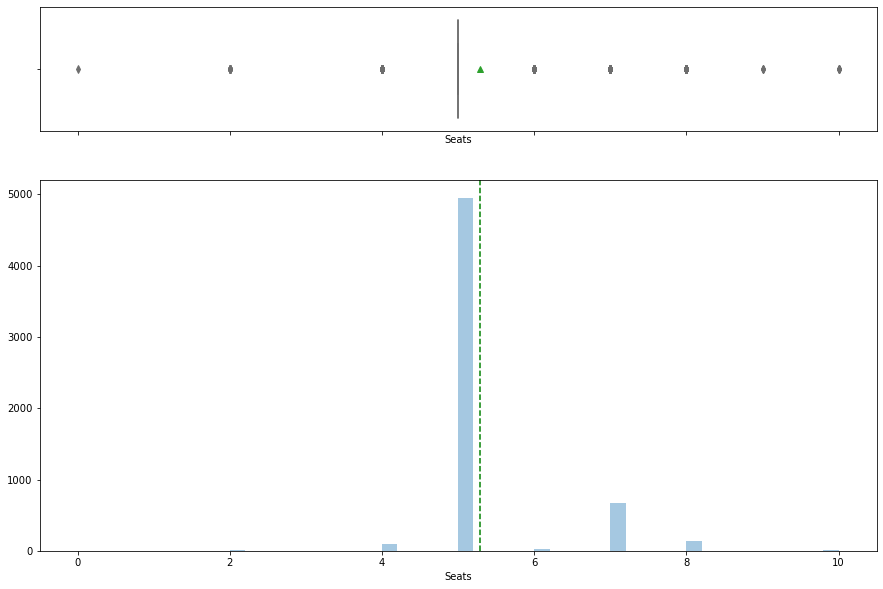

In [87]:
#Plot seats
histogram_boxplot(c4u2["Seats"])

In [88]:
# plt.figure(figsize=(8,5))
# ax = sns.countplot(c4u2["Seats"],palette='pastel')
# perc_on_bar(ax,c4u2["Seats"])

In [89]:
#describe seats
c4u2["Seats"].describe()

count    5898.000000
mean        5.281960
std         0.807807
min         0.000000
25%         5.000000
50%         5.000000
75%         5.000000
max        10.000000
Name: Seats, dtype: float64

In [90]:
#check seats nulls
sn = c4u2.loc[(c4u2.Seats.isnull())]
print(sn.shape)

(6, 15)


#### Observations
There are 9 types of seats

5 Seats is by far the most common with 84% with 7 seats following with 11%

0 & 9 seats have 0 observations

There are 7 missing values that need to be imputed to 5 seats

In [91]:
# check seats nulls
c4u2.loc[(c4u2.Seats.isnull())]

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
3800,Ford,Mumbai,2012,129000,Diesel,Automatic,First,12.8,2953.0,18.19,NaN,7.00,Endeavour,Hurricane LE,9
229,Ford,Bangalore,2015,70436,Diesel,Manual,First,18.2,1498.0,99.00,NaN,3.60,Figo,Diesel,6
3882,Maruti,Kolkata,2010,40000,Petrol,Manual,Second,19.5,1061.0,18.19,NaN,2.50,Estilo,LXI,11
5893,Maruti,Chennai,2008,51000,Petrol,Manual,Second,19.5,1061.0,18.19,NaN,1.75,Estilo,LXI,13
1917,Honda,Jaipur,2005,88000,Petrol,Manual,Second,13.0,1493.0,100.00,NaN,1.70,City,1.5 EXI,16
2369,Maruti,Chennai,2008,56000,Petrol,Manual,Second,19.5,1061.0,18.19,NaN,1.50,Estilo,LXI,13


In [92]:
# Impute seats to median
c4u2.loc[(c4u2.Seats.isnull()),'Seats'] = 5.0
c4u2.loc[(c4u2.Seats.isnull())]

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,


### Quick visulaization of distributions

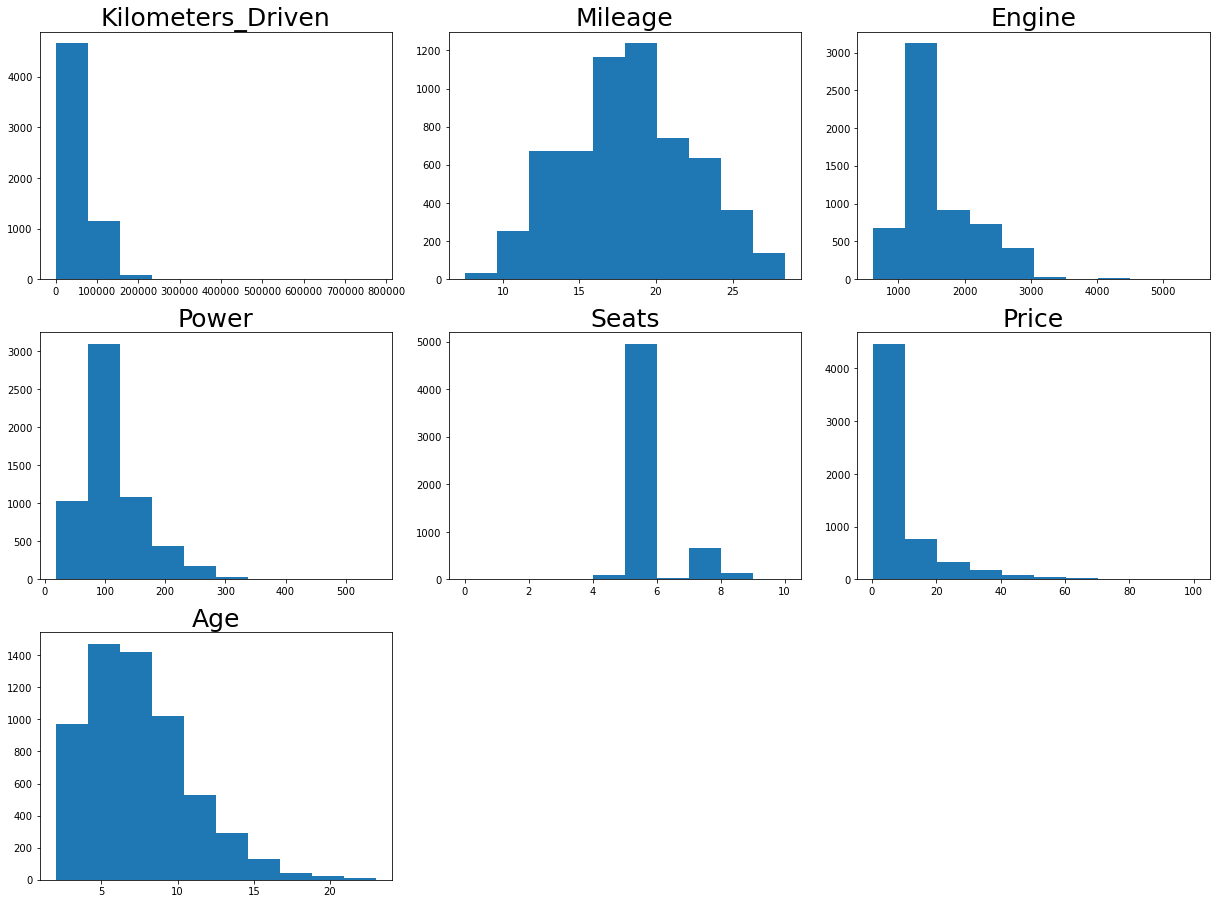

In [93]:
# lets plot histogram of all numerical variables

all_col = c4u2.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(17, 75))

for i in range(len(all_col)):
    plt.subplot(18, 3, i + 1)
    plt.hist(c4u2[all_col[i]])
    # sns.histplot(df[all_col[i]], kde=True)  # you can comment the previous line and run this one to get distribution curves
    plt.tight_layout()
    plt.title(all_col[i], fontsize=25)

plt.show()

#### Observations
Kilometers Driven has many high outliers, even with removing some extreme.  CAP OUTLIERS and recheck distribution.  Rescale.

Mileage appears normal and scale is likely OK

Engine has some high outliers, even after removing some extreme values.  CAP OUTLIERS and recheck distribution.  Rescale.

Power has some high outliers, CAP OUTLIERS and recheck distribution.  Rescale.

Price has many outliers, CAP OUTLIERS at a higher IQR.  Rescale

Age is fairly normal and scale should be OK

#### Scale and build initial models prior to capping outliers

## Multi-Variate Analysis & Correlations

<AxesSubplot:>

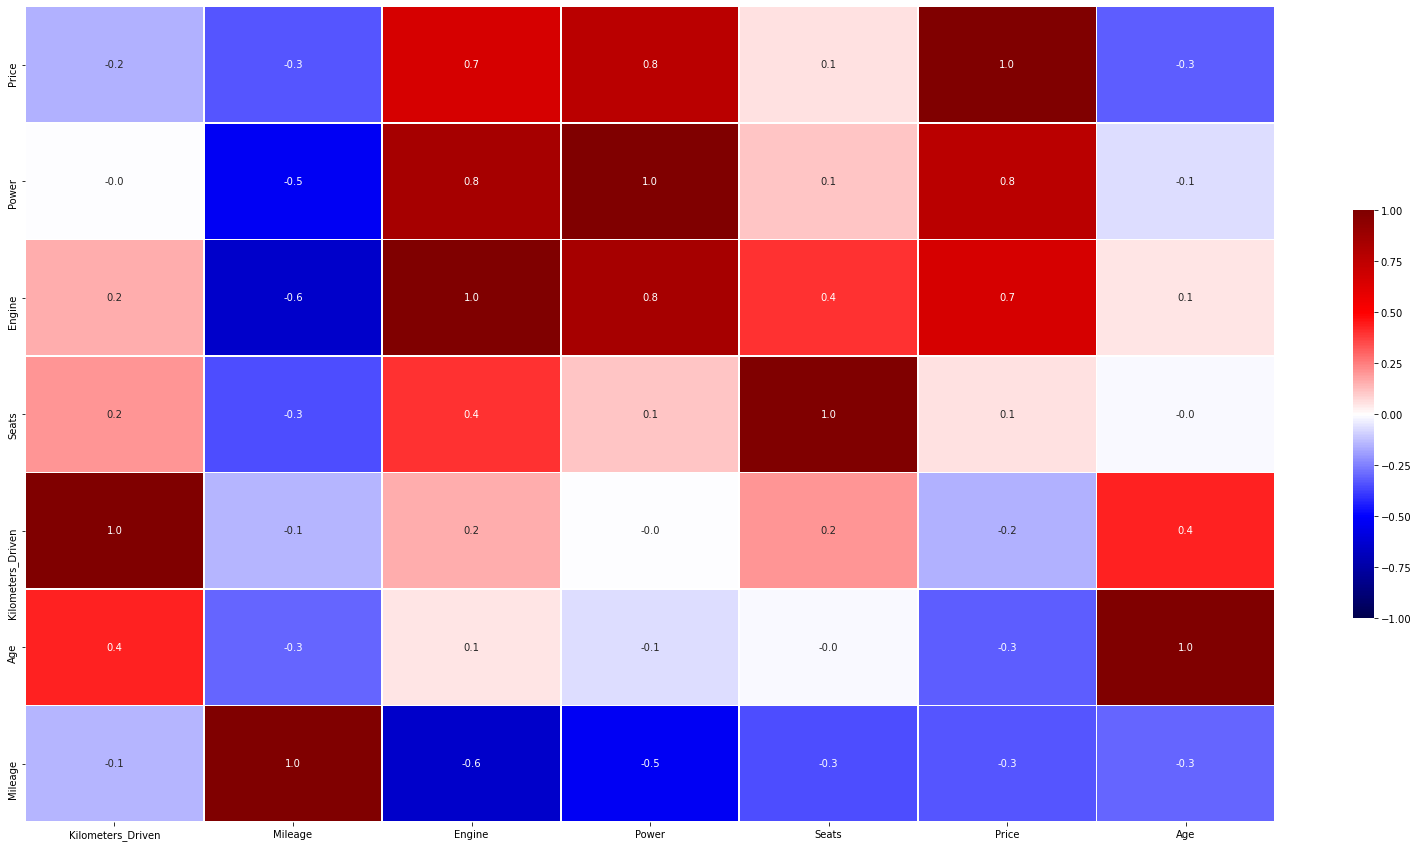

In [94]:
# Plot heat map
numeric_columns = c4u2.select_dtypes(include=np.number).columns.tolist()
corr = (
    c4u2[numeric_columns].corr().sort_values(by=["Price"], ascending=False)
)  # sorting correlations w.r.t life expectancy

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(28, 15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    cmap="seismic",
    annot=True,
    fmt=".1f",
    vmin=-1,
    vmax=1,
    center=0,
    square=False,
    linewidths=0.7,
    cbar_kws={"shrink": 0.5},
)

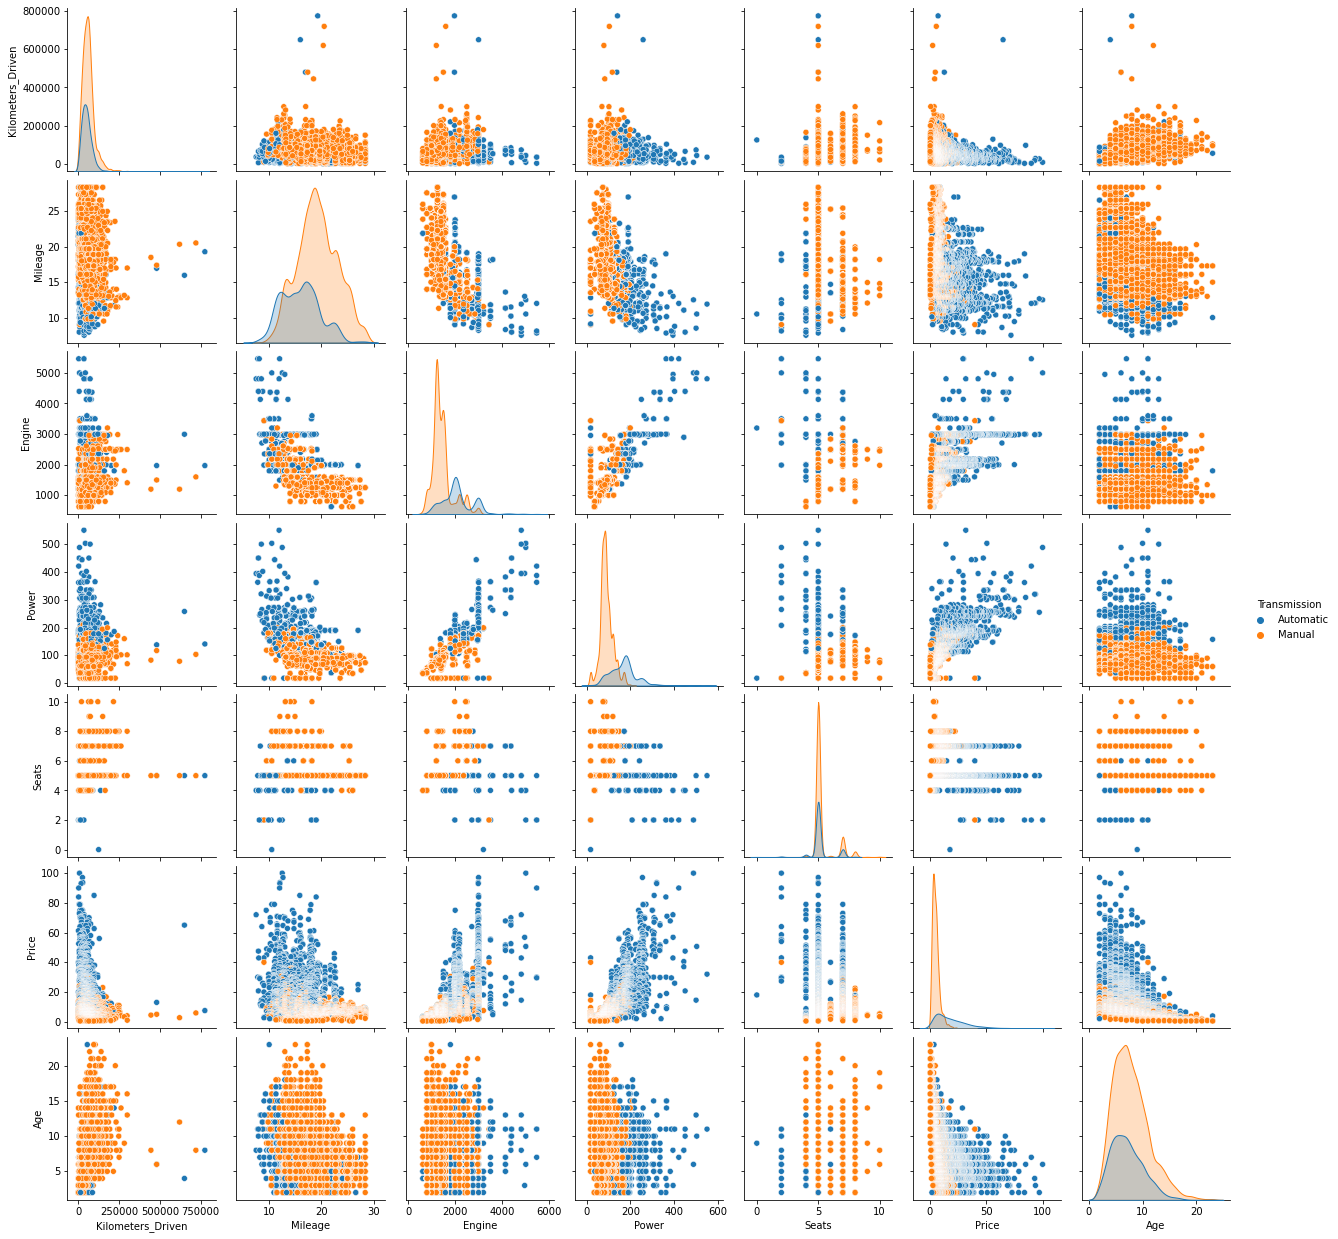

In [95]:
# Check correlation via pairplot
cols_to_exclude = ['Sub_Class', 'Model', 'S.No.']
sns.pairplot(c4u2[[colname for colname in c4u2.columns if colname not in cols_to_exclude]], hue = 'Transmission')

#### Observations
Power (0.8) and Engine (0.7) have the highest correlation to price.  All other numeric variables are < 0.3 or -0.3

KM Driven and Age are mildly correlated

Engine, Power & Mileage have high correlation as would be expected.  These are top candidates for dropping once building models

Seats have very low correlation to any other variable

Age has mild correlation to KM Driven (0.4) - A higher correlation was expected, see how they perform in the model

Transmission seems to play a role in mileage and power, with mileage being somewhat negatively impacted by manual trans

Most higher power and larger engines seem to be automatic transmission

Automatic transmission make up the bulk of higher KM Driven values


### Check some potential key variables with Price

#### Price & Power

<AxesSubplot:xlabel='Power', ylabel='Price'>

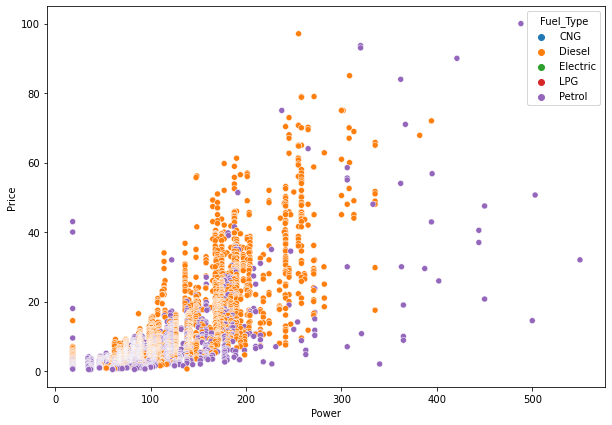

In [96]:
#plot price and power
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Power", hue="Fuel_Type", data=c4u2)

The highest power and priced cars are Petrol fuel

Cap power outliers above 300 when needed

#### Price and Engine

<AxesSubplot:xlabel='Engine', ylabel='Price'>

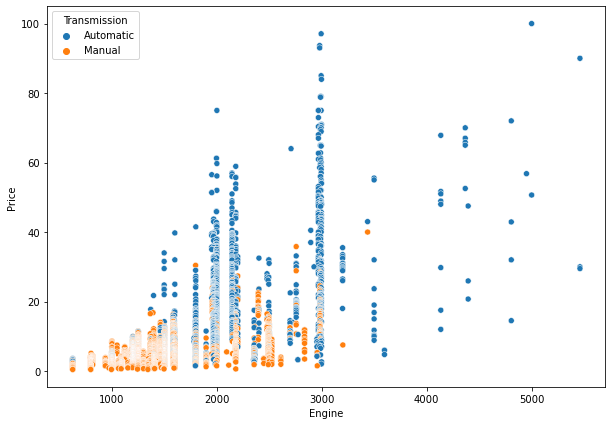

In [97]:
#plot price and engine
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Engine", hue="Transmission", data=c4u2)

Engines around 3000 cc are mostly automatic and range across the price spectrum

Cap engine outliers above 3000 when needed

#### Price and Age

<AxesSubplot:xlabel='Age', ylabel='Price'>

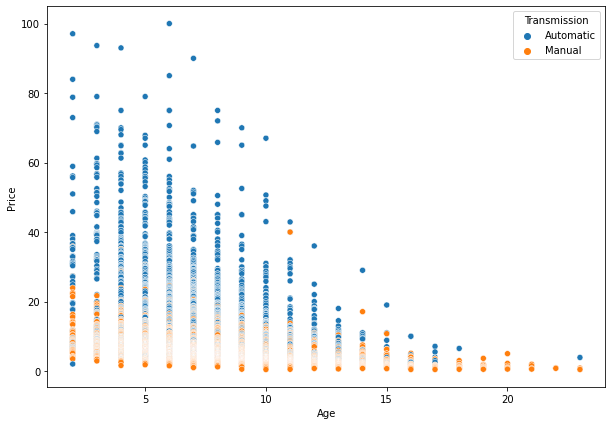

In [98]:
#plot price and age
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Age", hue="Transmission", data=c4u2)

Price and age have relatively low correlation

Price drops steadily throughout age

Cap Outliers at ~15 when needed

#### Price and Kilometers Driven

<AxesSubplot:xlabel='Kilometers_Driven', ylabel='Price'>

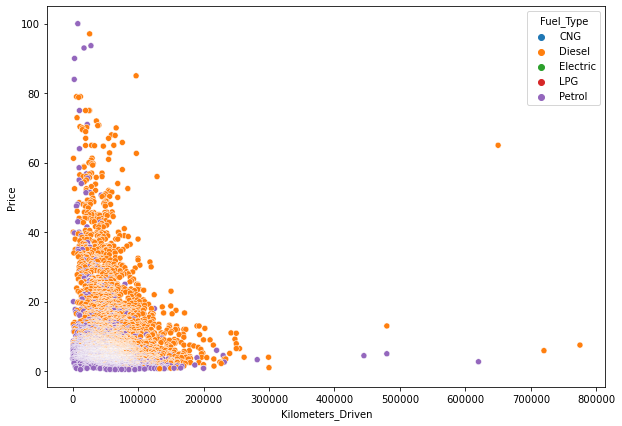

In [99]:
# plot price and kmd
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Kilometers_Driven", hue="Fuel_Type", data=c4u2)

### KM driven still has far too many high outliers, cap around 200000 prior to scaling and building model

As would be expected price drops at a steady rate as KM Driven rises, a correlation of -0.1 may be due to outliers.  Check correlation after capping outliers.

In [100]:
# treat KMD outliers
treat_outliers_high(c4u2, 'Kilometers_Driven')

,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
5919,Jaguar,Hyderabad,2015,8000.0,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,100.00,F,Type 5.0 V8 S,6
1505,Land_Rover,Kochi,2019,26013.0,Diesel,Automatic,First,12.65,2993.0,255.0,5.0,97.07,Range_Rover,Sport SE,2
1974,BMW,Coimbatore,2018,28060.0,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,93.67,7,Series 740Li,3
1984,BMW,Bangalore,2017,17465.0,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,93.00,7,Series 740Li,4
4691,Mercedes-Benz,Bangalore,2014,3000.0,Petrol,Automatic,Second,12.00,5461.0,421.0,2.0,90.00,SLK-Class,55 AMG,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,Tata,Jaipur,2010,57000.0,Petrol,Manual,First,26.00,624.0,35.0,4.0,0.50,Nano,Cx,11
2847,Hyundai,Pune,2005,86000.0,Petrol,Manual,Second,15.30,1341.0,83.0,5.0,0.45,Getz,GLS,16
1628,Maruti,Jaipur,2004,12000.0,Petrol,Manual,Second,16.10,796.0,37.0,4.0,0.45,800,Std BSIII,17


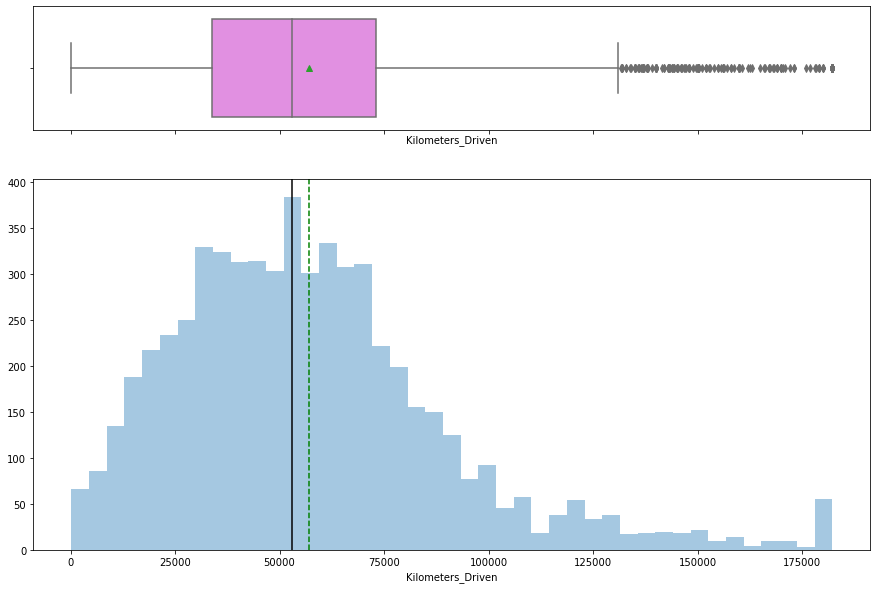

In [101]:
#plot KMD
histogram_boxplot(c4u2["Kilometers_Driven"])

<AxesSubplot:xlabel='Kilometers_Driven', ylabel='Price'>

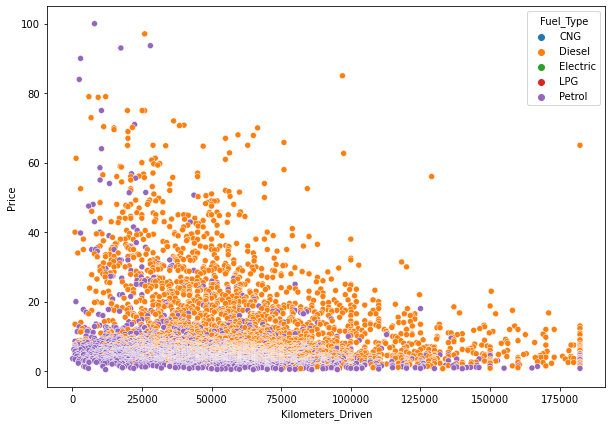

In [102]:
# plot price and KMD
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Kilometers_Driven", hue="Fuel_Type", data=c4u2)

In [103]:
#check price and KMD correlation
np.corrcoef(c4u2.Price,c4u2.Kilometers_Driven)

array([[ 1.        , -0.18462226],
       [-0.18462226,  1.        ]])

Distribution looks better and has capped outliers around 190000

Correlation between KM Driven and Price has only increased by apx -0.05

Diesel fuel appears to account for most higher priced cars, this is counter intuitive given most higher performance cars are petrol, this should be investigated more closely


#### Price and Mileage

<AxesSubplot:xlabel='Mileage', ylabel='Price'>

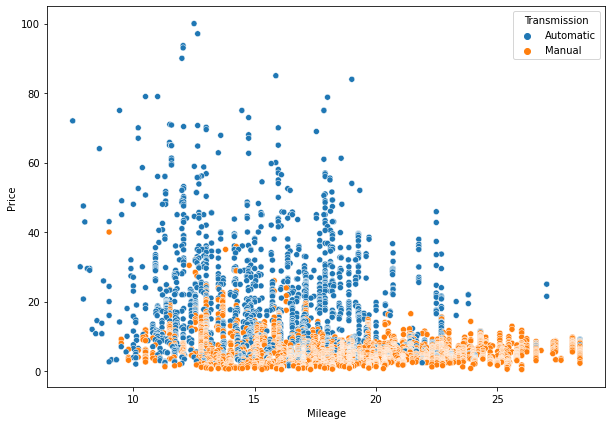

In [104]:
# plot price and mileage, transmission hue
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Mileage", hue="Transmission", data=c4u2)

Mileage and price are mildly correlated (-0.3)

The majority of higher mileage cars (> 20) has a manual transmission and also have a lower cost.  Likely due to these models having lower power and engine size.

In [105]:
#  Charges and sex
# fig, ax =plt.subplots(1,2, figsize= (20,15))
# sns.kdeplot(x='Price', hue='Location', fill=True, data=c4u2)
# sns.boxplot(x="Price", y="Location", data=c4u2, ax=ax[1])
# fig.show()

<AxesSubplot:xlabel='Price', ylabel='Location'>

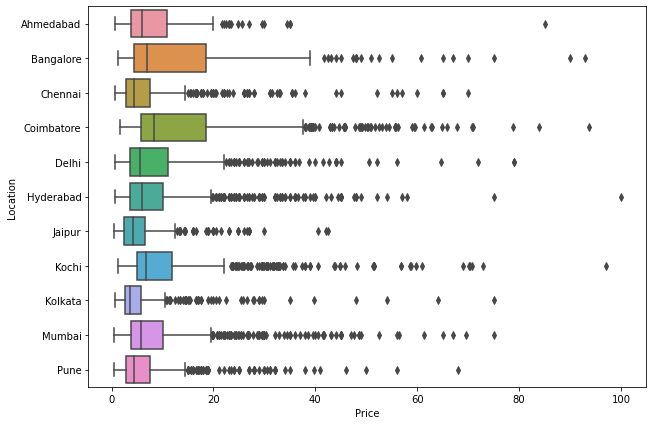

In [106]:
# plot price and location
plt.figure(figsize=(10, 7))
sns.boxplot(x="Price", y="Location", data=c4u2)

#### Observations
Price across locations are mostly even with Mumbai, Hyberdad (most cars located here) showing very similar IQR and mean, however Hyberdad is showing fewer outliers so could be a more stable target for predictions.

Bangalore & Coimbatore are showing the highest mean prices



<AxesSubplot:xlabel='Age', ylabel='Location'>

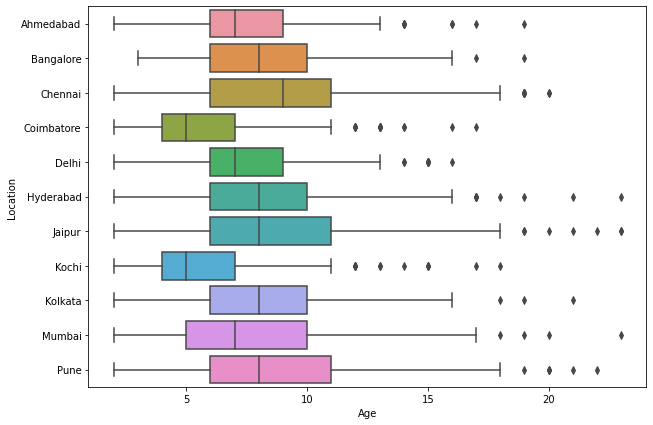

In [107]:
# plot age and location
plt.figure(figsize=(10, 7))
sns.boxplot(x="Age", y="Location", data=c4u2)

#### Observations
Median age across locatons range from 5 to ~7 years
Kochi and Coimbatore are showing the 'youngest' cars with a median age of 5.  

<AxesSubplot:xlabel='Engine', ylabel='Location'>

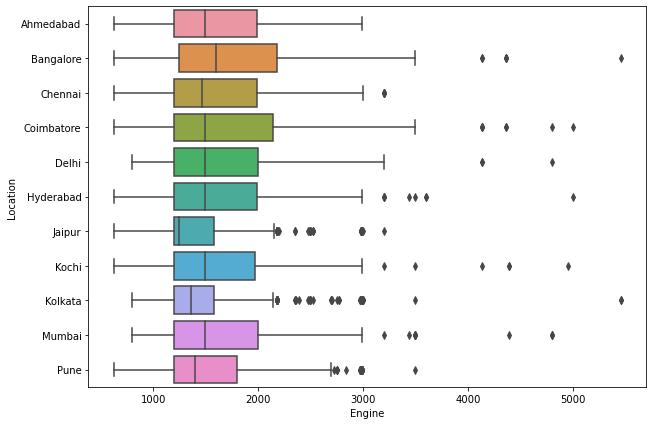

In [108]:
# plot engine and location
plt.figure(figsize=(10, 7))
sns.boxplot(x="Engine", y="Location", data=c4u2)

#### Observations
Engine sizes are fairly stable across locations at a mean around 7.25

Combatore has the larges range of engine sizes

<AxesSubplot:xlabel='Kilometers_Driven', ylabel='Location'>

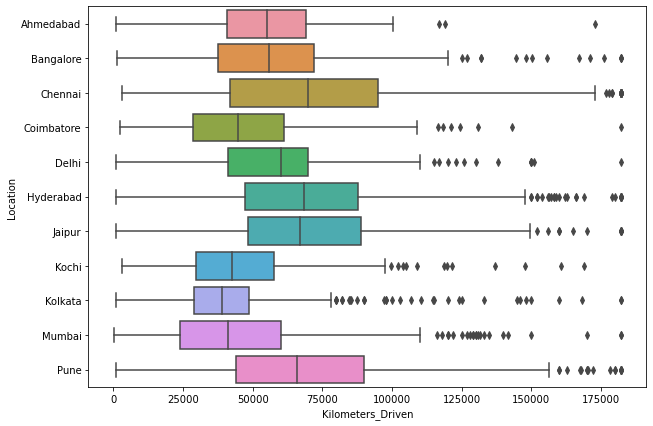

In [109]:
# plot KMD and location
plt.figure(figsize=(10, 7))
sns.boxplot(x="Kilometers_Driven", y="Location", data=c4u2)

#### Observation
Mumbai & Chennai have the widest range of KM Driven with Mumbai having a lower mean by ~80000 KM

<AxesSubplot:xlabel='Age', ylabel='Power'>

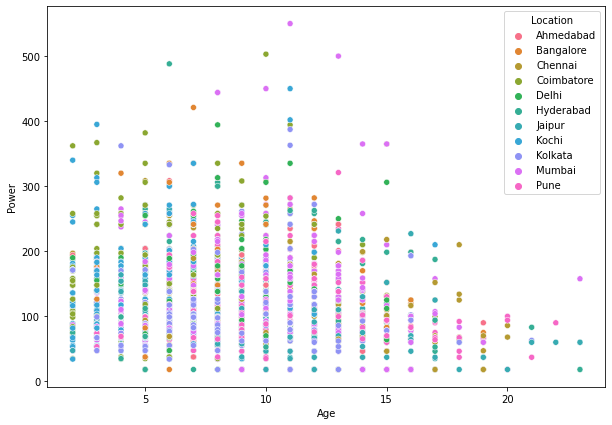

In [110]:
# Plot power and age
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Power", x="Age", hue="Location", data=c4u2)

#### Observations
Power and age seem to be evenly distributed across locations

Power seems to be evenly distributed under the age of 15


<AxesSubplot:xlabel='Age', ylabel='Price'>

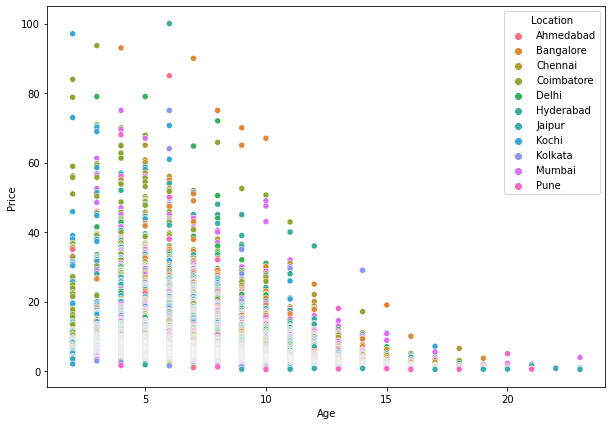

In [111]:
#plot price and age
plt.figure(figsize=(10, 7))
sns.scatterplot(y="Price", x="Age", hue="Location", data=c4u2)

#### Observations
Price and age look evenly distributed across location


<AxesSubplot:xlabel='Price', ylabel='Density'>

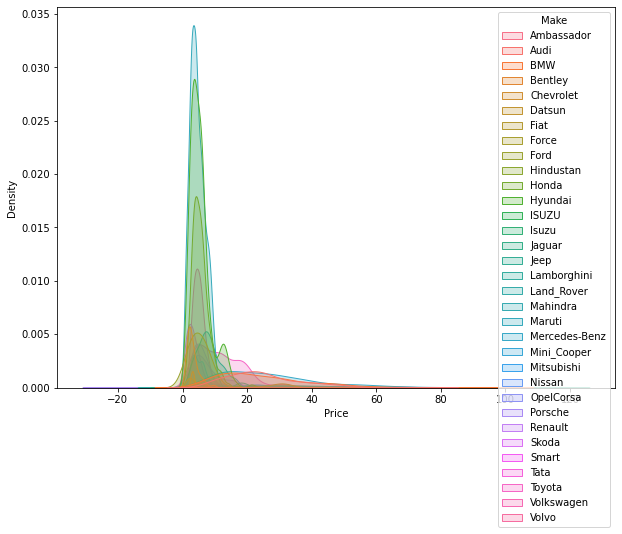

In [112]:
#plot price and make
plt.figure(figsize=(10, 7))
sns.kdeplot(x='Price', hue='Make', fill=True, data=c4u2)

### EDA Conclusions & Recommendations


1. Mumbai and Hyberdad are where most of the used cars are located and are fairly evenly distributed across attributes.  These locations should be investigated in more detail to determine approach

2. Combatore is 4th in the number of cars, has some of the 'youngest' cars, and the widest range of engine sizes and the highest prices.  Kolkata & Jaipur have the lowes prices.  Consider finding cars in Koldata & Jaipur and selling Combatore.

3. Investigate why Combatore has such an interesting dynamic.

## Transform Features
#### Check best method for - Engine, Power, Kilometers_Driven, Price


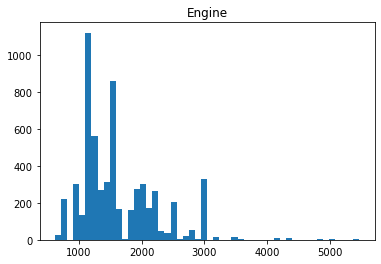

0


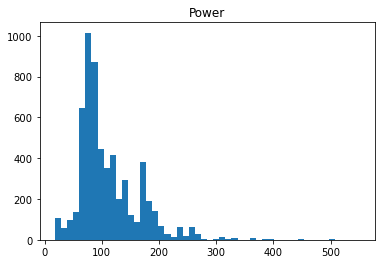

0


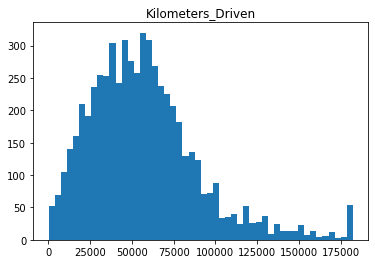

0


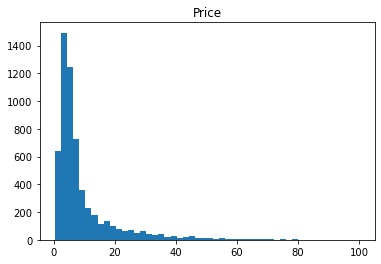

0


In [113]:
# Check each feature to transform shape and non-positive values
cols_to_log = ['Engine', 'Power', 'Kilometers_Driven', 'Price']
for colname in cols_to_log:
    plt.hist(c4u2[colname], bins=50)
    plt.title(colname)
    plt.show()
    print(np.sum(c4u2[colname] <= 0))

There are no non-positive values.

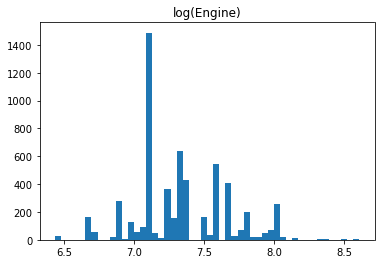

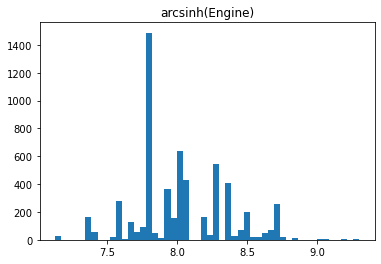

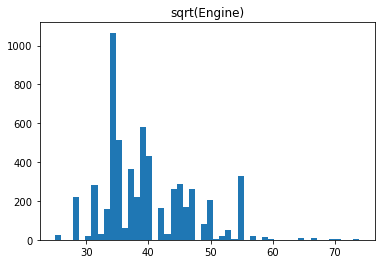

In [114]:
#check Engine with different methods
plt.hist(np.log(c4u2['Engine']), 50)
plt.title('log(Engine)')
plt.show()
plt.hist(np.arcsinh(c4u2['Engine']), 50)
plt.title('arcsinh(Engine)')
plt.show()
plt.hist(np.sqrt(c4u2['Engine']), 50)
plt.title('sqrt(Engine)')
plt.show()

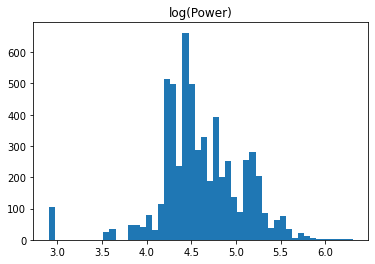

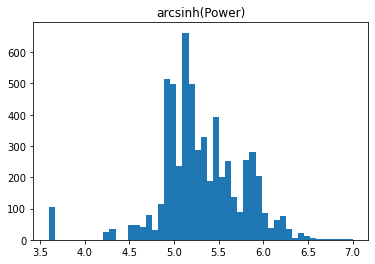

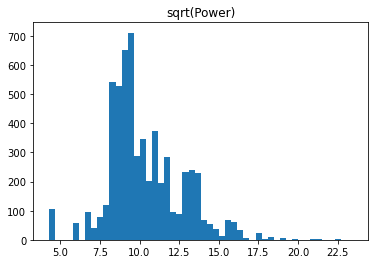

In [115]:
#check Power with different methods
plt.hist(np.log(c4u2['Power']), 50)
plt.title('log(Power)')
plt.show()
plt.hist(np.arcsinh(c4u2['Power']), 50)
plt.title('arcsinh(Power)')
plt.show()
plt.hist(np.sqrt(c4u2['Power']), 50)
plt.title('sqrt(Power)')
plt.show()

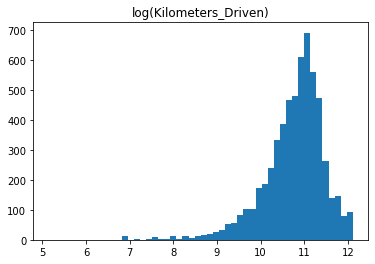

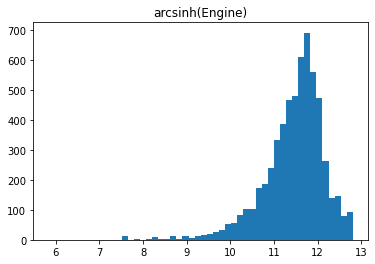

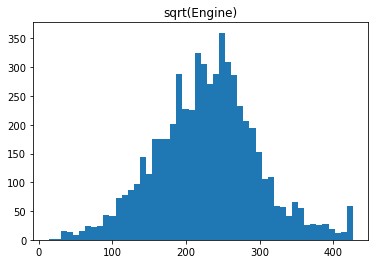

In [116]:
#check Kilometers_Driven with different methods
plt.hist(np.log(c4u2['Kilometers_Driven']), 50)
plt.title('log(Kilometers_Driven)')
plt.show()
plt.hist(np.arcsinh(c4u2['Kilometers_Driven']), 50)
plt.title('arcsinh(Engine)')
plt.show()
plt.hist(np.sqrt(c4u2['Kilometers_Driven']), 50)
plt.title('sqrt(Engine)')
plt.show()

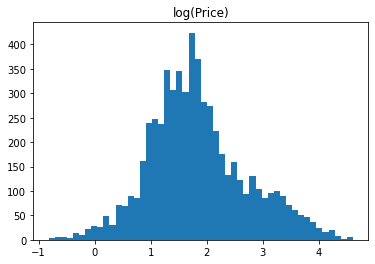

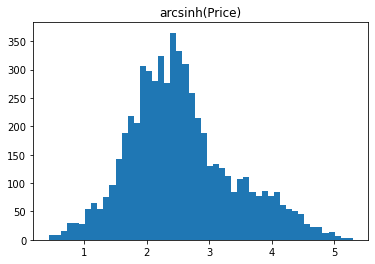

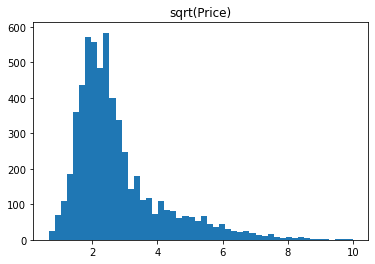

In [117]:
#check Price with different methods
plt.hist(np.log(c4u2['Price']), 50)
plt.title('log(Price)')
plt.show()
plt.hist(np.arcsinh(c4u2['Price']), 50)
plt.title('arcsinh(Price)')
plt.show()
plt.hist(np.sqrt(c4u2['Price']), 50)
plt.title('sqrt(Price)')
plt.show()

#### Methods show similar distributions with sqrt being slightly more right skewed and higher scale for Engine & Power. Use Log

#### Log shows significant improvement in distribution for price, however produces negative numbers.  Use arcsinh

#### Sqrt shows significant improvement for Kilometers Driven - However we may still want to treat the units to be closer to other Features


In [118]:
# Create a new DataFrame to work from and perform transformations
cdf = c4u2
print(type(cdf))
display(cdf)

<class 'pandas.core.frame.DataFrame'>


,Make,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Model,Sub_Class,Age
S.No.,,,,,,,,,,,,,,,
5919,Jaguar,Hyderabad,2015,8000.0,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,100.00,F,Type 5.0 V8 S,6
1505,Land_Rover,Kochi,2019,26013.0,Diesel,Automatic,First,12.65,2993.0,255.0,5.0,97.07,Range_Rover,Sport SE,2
1974,BMW,Coimbatore,2018,28060.0,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,93.67,7,Series 740Li,3
1984,BMW,Bangalore,2017,17465.0,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,93.00,7,Series 740Li,4
4691,Mercedes-Benz,Bangalore,2014,3000.0,Petrol,Automatic,Second,12.00,5461.0,421.0,2.0,90.00,SLK-Class,55 AMG,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,Tata,Jaipur,2010,57000.0,Petrol,Manual,First,26.00,624.0,35.0,4.0,0.50,Nano,Cx,11
2847,Hyundai,Pune,2005,86000.0,Petrol,Manual,Second,15.30,1341.0,83.0,5.0,0.45,Getz,GLS,16
1628,Maruti,Jaipur,2004,12000.0,Petrol,Manual,Second,16.10,796.0,37.0,4.0,0.45,800,Std BSIII,17


#### Drop unneeded features 
#### Year, Model, Sub_Class

In [119]:
# drop columns no longer needed
print(cdf.shape)
print(cdf.columns)
cdf.drop('Year', inplace=True, axis=1)
cdf.drop('Model', inplace=True, axis=1)
cdf.drop('Sub_Class', inplace=True, axis=1)
print(cdf.shape)
print(cdf.columns)

(5904, 15)
Index(['Make', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price', 'Model', 'Sub_Class', 'Age'],
      dtype='object')
(5904, 12)
Index(['Make', 'Location', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'Price', 'Age'],
      dtype='object')


#### Transform Engine (Log), Power (Log), Kilometers_Driven (Sqrt), Price (arcsinh)

In [120]:
#Perform transformation
print('DataFrame before transformations')
display(cdf.head())
cdf['Engine'] = np.log(cdf['Engine'])
cdf['Power'] = np.log(cdf['Power'])
cdf['Kilometers_Driven'] = np.sqrt(cdf['Kilometers_Driven'])
cdf['Price'] = np.arcsinh(cdf['Price'])
print('')
print('')
print('DataFrame after transformations')
display(cdf.head())

DataFrame before transformations


,Make,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age
S.No.,,,,,,,,,,,,
5919,Jaguar,Hyderabad,8000.0,Petrol,Automatic,First,12.50,5000.0,488.1,2.0,100.00,6
1505,Land_Rover,Kochi,26013.0,Diesel,Automatic,First,12.65,2993.0,255.0,5.0,97.07,2
1974,BMW,Coimbatore,28060.0,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,93.67,3
1984,BMW,Bangalore,17465.0,Petrol,Automatic,First,12.05,2979.0,320.0,5.0,93.00,4
4691,Mercedes-Benz,Bangalore,3000.0,Petrol,Automatic,Second,12.00,5461.0,421.0,2.0,90.00,7




DataFrame after transformations


,Make,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Age
S.No.,,,,,,,,,,,,
5919,Jaguar,Hyderabad,89.442719,Petrol,Automatic,First,12.50,8.517193,6.190520,2.0,5.298342,6
1505,Land_Rover,Kochi,161.285461,Diesel,Automatic,First,12.65,8.004032,5.541264,5.0,5.268606,2
1974,BMW,Coimbatore,167.511194,Petrol,Automatic,First,12.05,7.999343,5.768321,5.0,5.232954,3
1984,BMW,Bangalore,132.155212,Petrol,Automatic,First,12.05,7.999343,5.768321,5.0,5.225776,4
4691,Mercedes-Benz,Bangalore,54.772256,Petrol,Automatic,Second,12.00,8.605387,6.042633,2.0,5.192988,7


#### Check for missing values, correct features and types before moving on

In [121]:
# Check for missing values before moving on
display(cdf.info())
findNulls(cdf)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5904 entries, 5919 to 1713
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Make               5904 non-null   category
 1   Location           5904 non-null   category
 2   Kilometers_Driven  5904 non-null   float64 
 3   Fuel_Type          5904 non-null   category
 4   Transmission       5904 non-null   category
 5   Owner_Type         5904 non-null   category
 6   Mileage            5904 non-null   float64 
 7   Engine             5904 non-null   float64 
 8   Power              5904 non-null   float64 
 9   Seats              5904 non-null   float64 
 10  Price              5904 non-null   float64 
 11  Age                5904 non-null   int64   
dtypes: category(5), float64(6), int64(1)
memory usage: 560.2 KB


None

,numOfNulls,percentOfNulls
Age,0,0.0
Price,0,0.0
Seats,0,0.0
Power,0,0.0
Engine,0,0.0
Mileage,0,0.0
Owner_Type,0,0.0
Transmission,0,0.0
Fuel_Type,0,0.0
Kilometers_Driven,0,0.0


## Create Data for Modeling

In [122]:
# defining X and y variables and check
X = cdf.drop(["Price"], axis=1)
y = cdf[["Price"]]
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(5904, 11)
(5904, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [123]:
# check X & y
print('X')
display(X.head(2))
print('')
print('y')
display(y.head(2))

X


,Make,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Age
S.No.,,,,,,,,,,,
5919,Jaguar,Hyderabad,89.442719,Petrol,Automatic,First,12.50,8.517193,6.190520,2.0,6
1505,Land_Rover,Kochi,161.285461,Diesel,Automatic,First,12.65,8.004032,5.541264,5.0,2



y


,Price
S.No.,
5919,5.298342
1505,5.268606


### Create Dummy Variables
Make, Location, Fuel_Type, Owner_Type, Transmission

In [124]:
# create dummy variable for categorical 
X = pd.get_dummies(X, columns=['Make', 'Location', 'Fuel_Type', 'Owner_Type', 'Transmission'], drop_first=True)
display(X.shape)
display(X.head())

(5904, 56)

,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Bentley,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Hindustan,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Lamborghini,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_OpelCorsa,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5919,89.442719,12.50,8.517193,6.190520,2.0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1505,161.285461,12.65,8.004032,5.541264,5.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1974,167.511194,12.05,7.999343,5.768321,5.0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1984,132.155212,12.05,7.999343,5.768321,5.0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4691,54.772256,12.00,8.605387,6.042633,2.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


#### Creating dummy variables increased the number of features from 11 to 56

### Create Train & Test Data

In [125]:
# Create test and train data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2021
)

In [126]:
# Check train and test data
print('X_train')
display(X_train.shape)
display(X_train.head(2))
print('')
print('X_test')
display(X_test.shape)
display(X_test.head(2))
print('')
print('')
print('y_train')
display(y_train.shape)
display(y_train.head(2))
print('')
print('')
print('y_test')
display(y_test.shape)
display(y_test.head(2))

X_train


(4132, 56)

,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Bentley,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Hindustan,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Lamborghini,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_OpelCorsa,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4219,274.914532,25.10,7.311886,4.591071,5.0,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
2998,280.385449,14.84,7.669962,5.135798,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0



X_test


(1772, 56)

,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Bentley,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Force,Make_Ford,Make_Hindustan,Make_Honda,Make_Hyundai,Make_ISUZU,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Lamborghini,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_OpelCorsa,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3770,291.547595,11.0,8.002025,5.290789,5.0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2441,205.226704,18.3,7.087574,2.900872,5.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1




y_train


(4132, 1)

,Price
S.No.,
4219,2.644121
2998,3.435026




y_test


(1772, 1)

,Price
S.No.,
3770,2.997227
2441,1.525515


## Build, Train and Evaluate Linear Regression Model

In [127]:
# fitting the model on the train data (70% of the whole data)
from sklearn.linear_model import LinearRegression

linearregression = LinearRegression()
linearregression.fit(X_train, y_train)

LinearRegression()

In [128]:
# Check the coefficients and intercept of the model

coef_cdf = pd.DataFrame(
    np.append(linearregression.coef_[0], linearregression.intercept_[0]),
    index=X_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)

coef_cdf

,Coefficients
Kilometers_Driven,-8.948807e-04
Mileage,-1.447700e-02
Engine,8.045684e-01
Power,2.148476e-01
Seats,1.314756e-02
Age,-1.121430e-01
Make_Audi,4.681896e-01
Make_BMW,4.697265e-01
Make_Bentley,1.332268e-15
Make_Chevrolet,-5.203238e-01


In [129]:
# defining function for MAPE
def mape(targets, predictions):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# defining common function for all metrics
def model_perf(model, inp, out):
    """
    model: model
    inp: independent variables
    out: dependent variable
    """
    y_pred = model.predict(inp).flatten()
    y_act = out.values.flatten()

    return pd.DataFrame(
        {
            "MAE": mean_absolute_error(y_act, y_pred),
            "MAPE": mape(y_act, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
            "R^2": r2_score(y_act, y_pred),
        },
        index=[0],
    )

#### How to interpret the following statistics
The mean absolute percentage error (MAPE) measures the accuracy of predictions as a percentage, and can be calculated as the average absolute percent error for each predicted value minus actual values divided by actual values. It works best if there are no extreme values in the data and none of the actual values are 0.


The mean absolute error (MAE) is the simplest regression error metric to understand. We'll calculate the residual for every data point, taking only the absolute value of each so that negative and positive residuals do not cancel out. We then take the average of all these residuals. Effectively, MAE describes the typical magnitude of the residuals.


The root mean square error (RMSE) is just like the MAE, but squares the difference before summing them all instead of using the absolute value, and then takes the square root of the value.


𝑅2  (or coefficient of determination) represents the proportion of variance (of y) that has been explained by the independent variables in the model. It provides an indication of goodness of fit of the model. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value (or mean) of y, disregarding the input features, would get a  𝑅2  of 0.0.

In [130]:
# Checking model performance on train set (seen 70% data)
print("Train Performance\n")
model_perf(linearregression, X_train, y_train)

Train Performance



,MAE,MAPE,RMSE,R^2
0,0.168434,7.738482,0.219772,0.931974


In [131]:
# Checking model performance on test set (seen 30% data)
print("Test Performance\n")
model_perf(linearregression, X_test, y_test)

Test Performance



,MAE,MAPE,RMSE,R^2
0,0.177817,8.163653,0.242575,0.919563


#### First run produced a MAPE that was infinite, check for non-positive values in variables
#### This issue was corrected by using a arcsinh transformation on Price to remove negative values initially introduced by the Log transformation

In [132]:
# Check if there are any 0's in the dataframe
cdf.isin([0]).any().any()

True

In [133]:
# Check specific columns for 0
display(cdf.isin([0]).Seats.any())
display(cdf.isin([0]).Price.any())
display(cdf.isin([0]).Mileage.any())
display(cdf.isin([0]).Age.any())
display(cdf.isin([0]).Kilometers_Driven.any())
display(cdf.isin([0]).Engine.any())
display(cdf.isin([0]).Power.any())

True

False

False

False

False

False

False

In [134]:
# check seats for 0
cdf['Seats'].sort_values(ascending=True)

S.No.
3999     0.0
5919     2.0
1078     2.0
1288     2.0
693      2.0
        ... 
1907    10.0
2575    10.0
917     10.0
814     10.0
2267    10.0
Name: Seats, Length: 5904, dtype: float64

In [135]:
# check price for 0 
cdf['Price'].sort_values(ascending=True)

S.No.
1713    0.426913
2847    0.436050
3138    0.436050
1628    0.436050
2605    0.481212
          ...   
4691    5.192988
1984    5.225776
1974    5.232954
1505    5.268606
5919    5.298342
Name: Price, Length: 5904, dtype: float64

### Observations
####  R^2 is showing very good score of 93% for Training data and 92% for Test data on the first model run, the initial model is a good fit.  

#### However MAPE is showing infinite which means there may be a problem in the base data such as a 0 value
#### Changing to arcsinh for Price transformation removed non-positive numbers with no change in R^2
#### MAE of 0.177 indicates that our current model is able to predict Price within a mean error of 0.177 Lakh on the test data.
#### MAPE of 8.16 on the test set suggests we can predict within 8% of the Price.

Overall very happy with the first model, explore further with additional statistics models.

## Linear Regression with statsmodel

In [136]:
# Linear regression model using statsmodel
# Add the required constant 
X = sm.add_constant(X)
X_train1, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=2021
)

olsmod0 = sm.OLS(y_train, X_train1)
olsres0 = olsmod0.fit()

print(olsres0.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1273.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        19:45:48   Log-Likelihood:                 397.61
No. Observations:                4132   AIC:                            -705.2
Df Residuals:                    4087   BIC:                            -420.5
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### R^2 and Adjusted R^2 are both 93% - Very good
#### AIC (-705.2) and BIC (-420.5) are both very low - Very good
#### The majority of p-values are 0 and considered significant.  Some of these are features that were thought to be dropped before training.  We will drop these features and recheck with statsmodel
#### Check assumptions and revisit the model

In [137]:
# Drop cols thought to be dropped earlier
X_Train_D = X_train1.drop(columns= ["Make_Bentley", "Make_Force", "Make_Hindustan", "Make_ISUZU", "Make_Lamborghini", 
              "Make_OpelCorsa",  "Fuel_Type_Electric", "Fuel_Type_LPG"], axis=1)
X_train2 = X_Train_D

In [138]:
X_train2.head(2)

,const,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4219,1.0,274.914532,25.10,7.311886,4.591071,5.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2998,1.0,280.385449,14.84,7.669962,5.135798,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [139]:
### Check statsmodel after new dropped features

In [140]:
# Statsmodel 
olsmod1 = sm.OLS(y_train, X_train2)
olsres1 = olsmod1.fit()

print(olsres1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1273.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        19:45:48   Log-Likelihood:                 397.61
No. Observations:                4132   AIC:                            -705.2
Df Residuals:                    4087   BIC:                            -420.5
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### Dropping the 8 features did not change the R^2, adjusted r^2, AIC or BIC 

## Check Linear Regression Assumptions

We will be checking the following Linear Regression assumptions:

1. No Multicollinearity

2. Mean of residuals should be 0

3. No Heteroscedasticity

4. Linearity of variables

5. Normality of error terms

### TEST FOR MULTICOLLINEARITY

In [141]:
# check VIF
vif_series1 = pd.Series(
    [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])], index=X_train2.columns
)
print("VIF Scores: \n\n{}\n".format(vif_series1))

VIF Scores: 

const                        0.000000
Kilometers_Driven            2.009160
Mileage                      4.289861
Engine                       8.257800
Power                        3.999576
Seats                        2.490627
Age                          2.402982
Make_Audi                         inf
Make_BMW                          inf
Make_Chevrolet                    inf
Make_Datsun                       inf
Make_Fiat                         inf
Make_Ford                         inf
Make_Honda                        inf
Make_Hyundai                      inf
Make_Isuzu                        NaN
Make_Jaguar                       inf
Make_Jeep                         inf
Make_Land_Rover                   inf
Make_Mahindra                     inf
Make_Maruti                       inf
Make_Mercedes-Benz                inf
Make_Mini_Cooper                  inf
Make_Mitsubishi                   inf
Make_Nissan                       inf
Make_Porsche                      in

#### many of the Makes and Fuel_Types are showing inf which likely reflects perfect multicollinearity between some of the features 
#### To check this we will remove all makes and fuel types and see how that impacts the overall model

## Advised by GreatLearning to keep these in as a VIF with infinite value means there isn't enought data to calculate significance.  Keep them in the Model.
### Reworking model from this point

In [142]:
#Dropping infinite VIF features
display(X_train2.shape)
X_Train_MF = X_train2.drop(columns= [], axis=1)
 
#  "Make_Audi", "Make_BMW", "Make_Chevrolet", "Make_Datsun", "Make_Fiat","Make_Ford","Make_Honda",
#                                     "Make_Hyundai", "Make_Isuzu", "Make_Jaguar", "Make_Jeep", "Make_Land_Rover", "Make_Mahindra",
#                                     "Make_Maruti", "Make_Mercedes-Benz", "Make_Mini_Cooper", "Make_Mitsubishi", "Make_Nissan",
#                                     "Make_Porsche", "Make_Renault", "Make_Skoda", "Make_Smart", "Make_Tata", "Make_Toyota", 
#                                     "Make_Volkswagen", "Make_Volvo", "Fuel_Type_Diesel", "Fuel_Type_Petrol"
                                    
display(X_Train_MF.head())
display(X_Train_MF.shape)
X_train3 = X_Train_MF

(4132, 49)

,const,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4219,1.0,274.914532,25.10,7.311886,4.591071,5.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2998,1.0,280.385449,14.84,7.669962,5.135798,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1340,1.0,281.069386,18.40,7.088409,4.463607,5.0,9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
4892,1.0,285.951045,26.59,7.129298,4.304065,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4191,1.0,167.332005,15.73,7.584773,5.160950,5.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


(4132, 49)

In [143]:
#Check VIF
vif_series2 = pd.Series(
    [variance_inflation_factor(X_train3.values, i) for i in range(X_train3.shape[1])], index=X_train3.columns
)
print("VIF Scores: \n\n{}\n".format(vif_series2))

VIF Scores: 

const                        0.000000
Kilometers_Driven            2.009160
Mileage                      4.289861
Engine                       8.257800
Power                        3.999576
Seats                        2.490627
Age                          2.402982
Make_Audi                         inf
Make_BMW                          inf
Make_Chevrolet                    inf
Make_Datsun                       inf
Make_Fiat                         inf
Make_Ford                         inf
Make_Honda                        inf
Make_Hyundai                      inf
Make_Isuzu                        NaN
Make_Jaguar                       inf
Make_Jeep                         inf
Make_Land_Rover                   inf
Make_Mahindra                     inf
Make_Maruti                       inf
Make_Mercedes-Benz                inf
Make_Mini_Cooper                  inf
Make_Mitsubishi                   inf
Make_Nissan                       inf
Make_Porsche                      in

#### Removing Make features, Fuel_Type features drops the number of features from 49 to 22
#### However no VIF is above 5 with most non-location features showing around 1.  
#### Without Multicollinarity check the statsmodel again

In [144]:
# Statsmodel
olsmod2 = sm.OLS(y_train, X_train3)
olsres2 = olsmod2.fit()

print(olsres2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1273.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        19:45:50   Log-Likelihood:                 397.61
No. Observations:                4132   AIC:                            -705.2
Df Residuals:                    4087   BIC:                            -420.5
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Keeping Model and Fuel_Type - below comments for documentation only

#### Reducing the multicollinarity has shown negative impact on the model's success
#### ols mod 1 had R^2 of 93%, Adj R^2 of 93%, AIC of -705 and BIC of -420
#### ols mod 2 has R^2 of 86%, Adj R^2 of 86%, AIC of 2134 and BIC of 2267
#### There are still p-values that are showing as not significant, however they are part of  categorical features and will be kept

In [145]:
# Drop columns and check
display(X_train3.shape)
X_Train_Final = X_train3.drop(columns= [], axis=1)
#"Location_Chennai", "Owner_Type_Fourth & Above"
display(X_Train_Final.head())
display(X_Train_Final.shape)
X_train4 = X_Train_Final

(4132, 49)

,const,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4219,1.0,274.914532,25.10,7.311886,4.591071,5.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2998,1.0,280.385449,14.84,7.669962,5.135798,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1340,1.0,281.069386,18.40,7.088409,4.463607,5.0,9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
4892,1.0,285.951045,26.59,7.129298,4.304065,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4191,1.0,167.332005,15.73,7.584773,5.160950,5.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


(4132, 49)

In [146]:
# Statsmodel
olsmod3 = sm.OLS(y_train, X_train4)
olsres3 = olsmod3.fit()

print(olsres3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1273.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        19:45:50   Log-Likelihood:                 397.61
No. Observations:                4132   AIC:                            -705.2
Df Residuals:                    4087   BIC:                            -420.5
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Keeping Model and Fuel_Type - below comments for documentation only

#### ols mod 2 has R^2 of 86%, Adj R^2 of 86%, AIC of 2134 and BIC of 2267

#### ols mod 3 has R^2 of 86%, Adj R^2 of 86%, AIC of 2132 and BIC of 2253

#### Tests with removing Kilometers_Driven, Engine & Power respectively resulted with a drop of 1-2% each.  Keeping even though they have shown high collinarity.



In [147]:
# drop cols and check
display(X_train4.shape)
X_Train_Final2 = X_train4.drop(columns= [], axis=1)
#"Location_Jaipur", "Location_Kochi"
display(X_Train_Final2.head())
display(X_Train_Final2.shape)
X_train5 = X_Train_Final2

(4132, 49)

,const,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4219,1.0,274.914532,25.10,7.311886,4.591071,5.0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2998,1.0,280.385449,14.84,7.669962,5.135798,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1340,1.0,281.069386,18.40,7.088409,4.463607,5.0,9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
4892,1.0,285.951045,26.59,7.129298,4.304065,5.0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
4191,1.0,167.332005,15.73,7.584773,5.160950,5.0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


(4132, 49)

In [148]:
# Statsmodel
olsmod4 = sm.OLS(y_train, X_train5)
olsres4 = olsmod4.fit()

print(olsres4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1273.
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        19:45:50   Log-Likelihood:                 397.61
No. Observations:                4132   AIC:                            -705.2
Df Residuals:                    4087   BIC:                            -420.5
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Keeping Model and Fuel_Type - below comments for documentation only
#### Dropping the remaining 2 features had very little impact on the overall model
#### We have moved from an initial model with 56 features to a final model with 17
#### We will consider this the final model 
#### Now adjusted R-squared is 0.863, our model is able to explain 86.3% of variance. This shows that the model is good.
#### The adjusted R-squared in olsres0 (where we considered all the variables) was 0.932. This shows that the variables we dropped were having a distinct impact on the model, but had very high collinearity

### Continue checking assumptions using model OLSMOD4

2. Mean of residuals should be 0 
3. Linearity of variables
4. Normality of error terms
5. No Heteroscedasticity

In [149]:
# Check residuals
residual = olsres4.resid
np.mean(residual)

1.5262680868536737e-13

#### Residuals should be close to 0, this fits

### Test for Linearity

In [150]:
# Test for linearily
residual = olsres4.resid
fitted = olsres4.fittedvalues  # predicted values

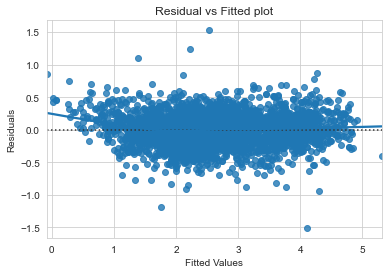

In [151]:
# Plot linearity test
sns.set_style("whitegrid")
sns.residplot(fitted, residual, lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual vs Fitted plot")
plt.show()

## As advised by Great Learning - Keeping Model and Fuel_Type 

## Initial model without Make showed only slight pattern so assumptions were met.  No time to rework before submitting.

#### We see a pattern in the plot above.  Work will need to be done to normalize .

### Test for Normality

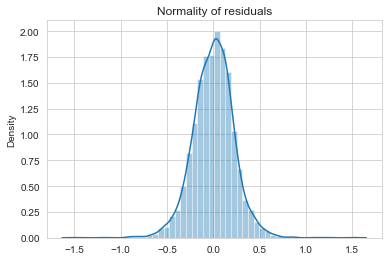

In [152]:
# check assumptions - normality
sns.distplot(residual)
plt.title("Normality of residuals")
plt.show()

#### Residuals show a fairly normal distribution in this plot.  Check QQ plot

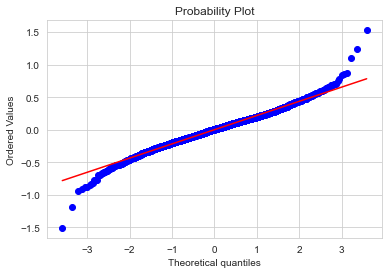

In [153]:
#QQ plot
stats.probplot(residual, dist="norm", plot=pylab)
plt.show()

## As advised by Great Learning - Keeping Model and Fuel_Type
## Initial QQ Plot showed fairly normal so assumptions were met. No time to rework before submitting.
#### The QQ Plot shows the residuals as fairly normal.  Some work with outliers could improve this.

### TEST FOR HOMOSCEDASTICITY

For goldfeldquandt test, the null and alternate hypotheses are as follows:

Null hypothesis : Residuals are homoscedastic

Alternate hypothesis : Residuals have heteroscedasticity

In [154]:
# check assumptions with goldfeldquant
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(residual, X_train5)
lzip(name, test)

[('F statistic', 1.0067490594874424), ('p-value', 0.4399098771880515)]

#### Since p-value > 0.05, we can say that the residuals are homoscedastic. This assumption is therefore valid in the data.

### Predicting on the Test Data

In [155]:
# Check train columns
X_train5.columns

Index(['const', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Age', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet', 'Make_Datsun',
       'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Isuzu',
       'Make_Jaguar', 'Make_Jeep', 'Make_Land_Rover', 'Make_Mahindra',
       'Make_Maruti', 'Make_Mercedes-Benz', 'Make_Mini_Cooper',
       'Make_Mitsubishi', 'Make_Nissan', 'Make_Porsche', 'Make_Renault',
       'Make_Skoda', 'Make_Smart', 'Make_Tata', 'Make_Toyota',
       'Make_Volkswagen', 'Make_Volvo', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Owner_Type_Fourth & Above',
       'Owner_Type_Second', 'Owner_Type_Third', 'Transmission_Manual'],
      dtype='object')

In [156]:
# Selecting columns from test data that we used to create our final model
X_test_final = X_test[X_train5.columns]
X_test_final.head(2)

,const,Kilometers_Driven,Mileage,Engine,Power,Seats,Age,Make_Audi,Make_BMW,Make_Chevrolet,Make_Datsun,Make_Fiat,Make_Ford,Make_Honda,Make_Hyundai,Make_Isuzu,Make_Jaguar,Make_Jeep,Make_Land_Rover,Make_Mahindra,Make_Maruti,Make_Mercedes-Benz,Make_Mini_Cooper,Make_Mitsubishi,Make_Nissan,Make_Porsche,Make_Renault,Make_Skoda,Make_Smart,Make_Tata,Make_Toyota,Make_Volkswagen,Make_Volvo,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_Petrol,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third,Transmission_Manual
S.No.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3770,1.0,291.547595,11.0,8.002025,5.290789,5.0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2441,1.0,205.226704,18.3,7.087574,2.900872,5.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1


In [157]:
# Checking model performance on train set 
print("Train Performance\n")
model_perf(olsres4, X_train5.values, y_train)

Train Performance



,MAE,MAPE,RMSE,R^2
0,0.168434,7.738482,0.219772,0.931974


In [158]:
# Checking model performance on test set 
print("Test Performance\n")
model_perf(olsres4, X_test_final.values, y_test)

Test Performance



,MAE,MAPE,RMSE,R^2
0,0.177817,8.163653,0.242575,0.919563


#### Now we can see that the model has low test and train RMSE and MAE, and both the errors are comparable. So, our model is not suffering from overfitting.

#### The model is able to explain 91% of the variation on the test set, which is very good.

#### The MAPE on the test set suggests we can predict within 8% of the Price. 


### Hence, we can conclude the model *olsres4* is good for prediction as well as inference purposes.

### Model Summary

In [159]:
# let us print the model summary
olsmod4 = sm.OLS(y_test, X_test)
olsres4 = olsmod4.fit()
print(olsres4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     468.4
Date:                Fri, 21 May 2021   Prob (F-statistic):               0.00
Time:                        19:45:55   Log-Likelihood:                 30.659
No. Observations:                1772   AIC:                             28.68
Df Residuals:                    1727   BIC:                             275.3
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [160]:
# check train5 shape for nubmer of cols
X_train5.shape

(4132, 49)

## Conslusion

OLSRES4 was the highest performing model that met linear regression assumptions and showed a good overall fit with the training data
- MAE      0.177
- MAPE     8.163
- RMSE     0.242
- R^2      0.923
- Adj R^2  0.921

This means OLSRES4 will be able to:
- Explain 92% of the datas variation          
- Predict within 8% of the used car Price

Key Variables for the model:
- Mileage
- Engine
- Power
- Age

                
Surprisingly Kilometers_Driven and Location showed very little significance in the overall performance of the model.  However these should not be removed from the model as more data could increase their significance and they could be important for ongoing insights.
                
Although the model shows good results some assumptions such as normality could be tightened through adding additional data and other methods to increase the reliability to make inferences from the model.   

12 Models were tested, most were iterations looking at outlier treatment, transformations and investigating problems with assumptions. Most of these are not shown, however are documented in the notebook
- There were 13 columns that resulted in 56 features going into the model
- The final model contains 49 features plus the target variable of Price     


#### Advised by GreatLearning to Keep Make & Fuel Type - Below comments are kept for documentation 
Make (previously Name) showed significant positive impact on the model (+10% R^2), however it caused assumptions to not be met by showing perfect multicollinarity and has potential to make the model unstable and so was removed.  It is possible that Make was highly correlated to Engine & Power.  This should be investigated further as Make would be an important feature for ongoing insights
                
Fuel_Type was removed due to perfect multicollinarity, possibly correlated to Engine and Power.  When included in the model it did not show significant impact.
                      
